<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [1] used 0.0742 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 119.65 MiB


Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 12s
In [2] used 1809.5352 MiB RAM in 72.23s, peaked 1938.62 MiB above current, total RAM usage 1929.18 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [3]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


In [3] used -1121.5000 MiB RAM in 1.85s, peaked 10.75 MiB above current, total RAM usage 654.96 MiB


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [8]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


In [8] used 3.0820 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 320.22 MiB


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

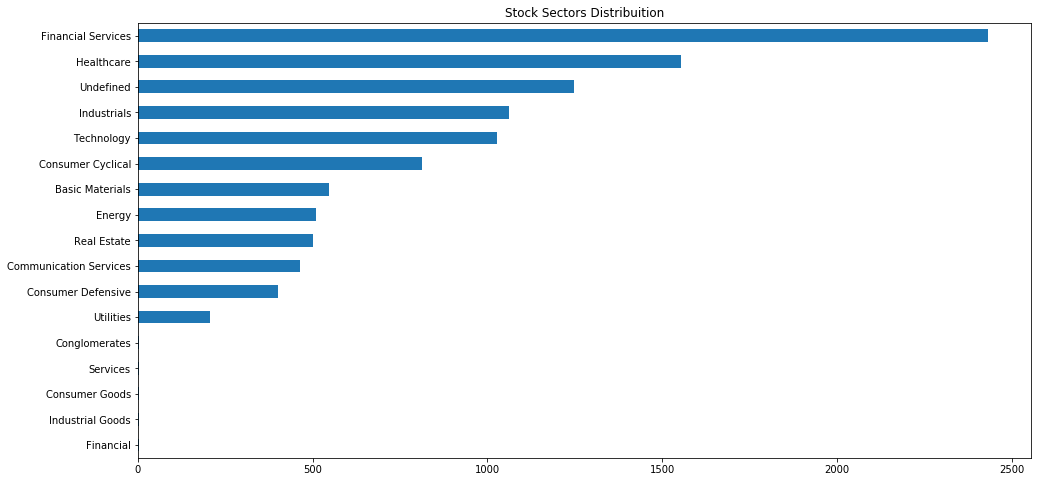

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [3]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [3] used 7.0742 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1936.26 MiB


Чищу данные.

In [4]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 28.5 s
In [4] used -1563.2266 MiB RAM in 28.68s, peaked 3822.25 MiB above current, total RAM usage 373.03 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [5]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

In [5] used 19.1016 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 462.99 MiB


Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [5]:
np.random.seed(10012021)
df = df[df.cik.isin(np.random.choice(df.cik.unique(), 800, replace=False)) & 
        df.ticker_id.isin(np.random.choice(df.ticker_id.unique(), 800, replace=False))]

In [5] used -314.8633 MiB RAM in 1.37s, peaked 527.18 MiB above current, total RAM usage 58.17 MiB


In [6]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 5.47 s
In [6] used -1.2539 MiB RAM in 5.58s, peaked 10.20 MiB above current, total RAM usage 56.91 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [9]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers_lookup, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by ticker')

0.392% covered by ticker
In [9] used 307.4492 MiB RAM in 1.61s, peaked 253.38 MiB above current, total RAM usage 627.67 MiB


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [7]:
out_universe = pd.DataFrame(columns=df.period.unique(),
             index=pd.MultiIndex.from_product([df.cik.unique(), df.ticker_id.unique()], names=["cik", "ticker_id"]))

out_universe = out_universe[~out_universe.index.isin(zip(df.cik.values, df.ticker_id.values))]\
               .isna().unstack().unstack().reset_index(name='nid_out')

out_universe.rename(columns={'level_0': 'period'}, inplace=True)
out_universe.shape

(4729725, 4)

In [7] used 203.0703 MiB RAM in 2.04s, peaked 203.95 MiB above current, total RAM usage 259.98 MiB


In [8]:
%%time

not_observed = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                                .isna().unstack().reset_index(name='nid')

not_observed = not_observed[not_observed.nid]
not_observed.shape

Wall time: 53.9 ms


(118966, 4)

In [8] used 8.2812 MiB RAM in 0.17s, peaked 0.93 MiB above current, total RAM usage 268.27 MiB


In [9]:
%%time

df = df.merge(out_universe, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))
del out_universe

df = df.merge(not_observed, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))
del not_observed

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 40 s
In [9] used 638.3086 MiB RAM in 40.14s, peaked 814.23 MiB above current, total RAM usage 906.57 MiB


In [10]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)
del df

print(str(final_df.shape[0]) + ' observations for ' + str(final_df.cik.nunique()) + ' funds, '
      + str(final_df.ticker_id.nunique()) + ' tickers and ' + str(final_df.period.nunique()) + ' periods!')

4729725 observations for 675 funds, 539 tickers and 13 periods!
In [10] used 0.0430 MiB RAM in 0.69s, peaked 17.83 MiB above current, total RAM usage 906.62 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [11]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [11] used 0.4805 MiB RAM in 0.39s, peaked 129.30 MiB above current, total RAM usage 907.10 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [12]:
funds_value.head()

,period,cik,market_value
258,2015Q3,1352851,62430000.0
682,2015Q4,80255,838000.0
888,2015Q4,1288136,53640000.0
933,2015Q4,1352851,55833000.0
969,2015Q4,1397424,94304000.0


In [12] used 0.1797 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 907.28 MiB


Рассмотрим некоторые основные описательные статистики.

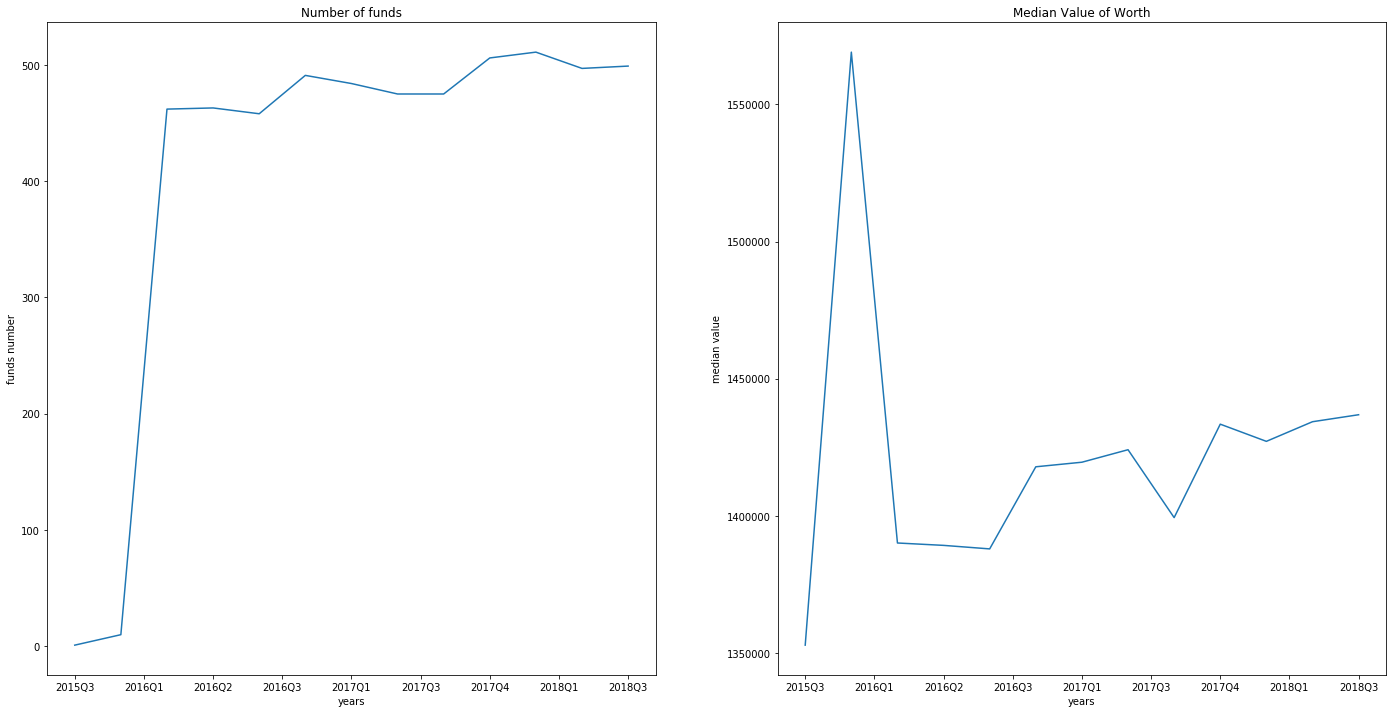

In [13] used 9.7969 MiB RAM in 0.56s, peaked 1.86 MiB above current, total RAM usage 917.07 MiB


In [13]:
fig, axs = pl.subplots(1, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0].set_title('Number of funds');
axs[0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1].set_title('Median Value of Worth');
axs[1].set(xlabel='years', ylabel='median value');
axs[1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [14]:
final_df = final_df[final_df.period >= '2016Q1']

In [14] used -122.4844 MiB RAM in 0.67s, peaked 554.66 MiB above current, total RAM usage 794.59 MiB


Теперь я посмотрю на распределение ценности фондов.

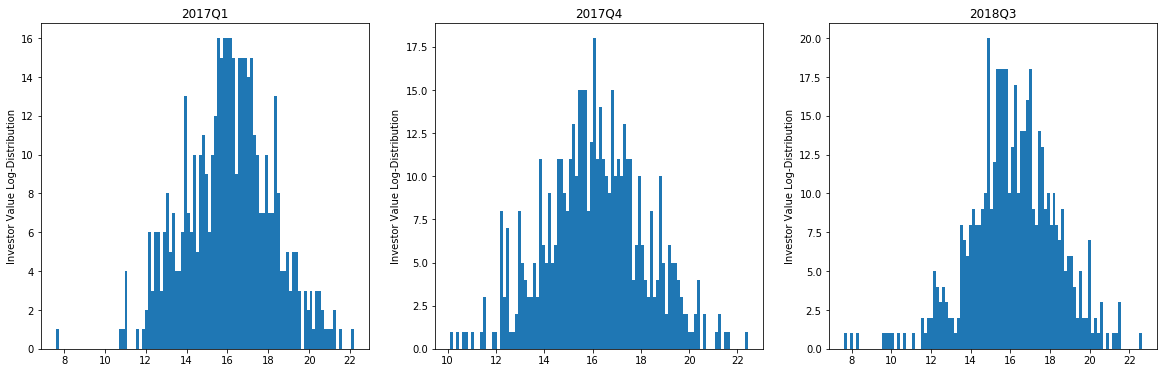

In [15] used 3.5117 MiB RAM in 0.80s, peaked 2.11 MiB above current, total RAM usage 798.10 MiB


In [15]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [16]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.qcut(final_df.market_value_fund, 10, labels=list(range(10)))

In [16] used 66.5430 MiB RAM in 3.03s, peaked 576.29 MiB above current, total RAM usage 864.64 MiB


In [17]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [17] used -130.8945 MiB RAM in 2.85s, peaked 736.73 MiB above current, total RAM usage 733.75 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [18]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 5.8 s
In [18] used 450.9492 MiB RAM in 5.92s, peaked 71.12 MiB above current, total RAM usage 1184.70 MiB


## Создание зависимой переменной

In [19]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [19] used 43.9570 MiB RAM in 0.42s, peaked 0.00 MiB above current, total RAM usage 1228.66 MiB


In [20]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [20] used 66.4297 MiB RAM in 3.45s, peaked 616.29 MiB above current, total RAM usage 1295.09 MiB


In [21]:
final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['close_lag_4'] = final_df.close.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

final_df['price_change_quarter'] = final_df.close.div(final_df.close_lag_1, axis=0).sub(1)
final_df['price_change_year'] = final_df.close.div(final_df.close_lag_4, axis=0).sub(1)

In [21] used 87.5664 MiB RAM in 0.99s, peaked 21.88 MiB above current, total RAM usage 1382.65 MiB


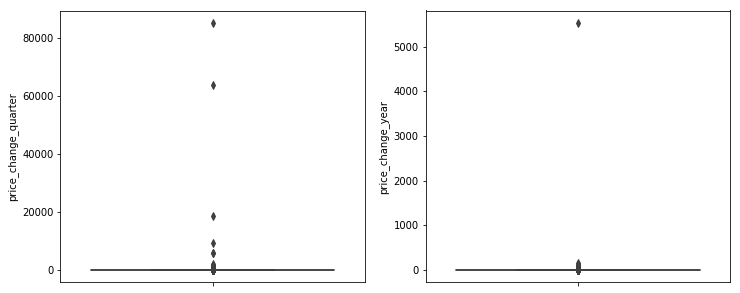

In [22] used -49.4922 MiB RAM in 1.18s, peaked 76.50 MiB above current, total RAM usage 1333.16 MiB


In [22]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

In [23]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 7.07 s
In [23] used 263.4336 MiB RAM in 7.17s, peaked 659.71 MiB above current, total RAM usage 1596.59 MiB


But at what cost?

In [24]:
final_df[final_df.net_changes < -1].net_changes

267050   -1.0
610334   -1.0
879365   -1.0
Name: net_changes, dtype: float64

In [24] used -0.0117 MiB RAM in 1.79s, peaked 1506.89 MiB above current, total RAM usage 1596.58 MiB


In [25]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(15)

,cik,period,ticker_id,shares,market_value,close,mode_close
7939,1409362,2018Q2,1993,20.0,1000.0,50.000000,29.314923
22149,1007280,2016Q4,2658,2499.0,97000.0,38.815526,31.790123
26839,769317,2017Q3,3061,62.0,1000.0,16.129032,23.835480
26840,769317,2017Q4,3061,62.0,1000.0,16.129032,24.139273
30494,1568679,2016Q2,3061,9372.0,1094000.0,116.730687,12.759333
31616,1677443,2016Q2,3061,46.0,1000.0,21.739130,12.759333
31625,1677443,2018Q3,3061,46.0,1000.0,21.739130,29.544643
31694,1690010,2018Q3,3061,27.0,1000.0,37.037037,29.544643
31901,1732854,2017Q4,3061,37.0,7000.0,189.189189,24.139273
33924,1316539,2016Q2,3122,32758.0,7570000.0,231.088589,242.424242


In [25] used 0.0664 MiB RAM in 0.19s, peaked 0.00 MiB above current, total RAM usage 1596.65 MiB


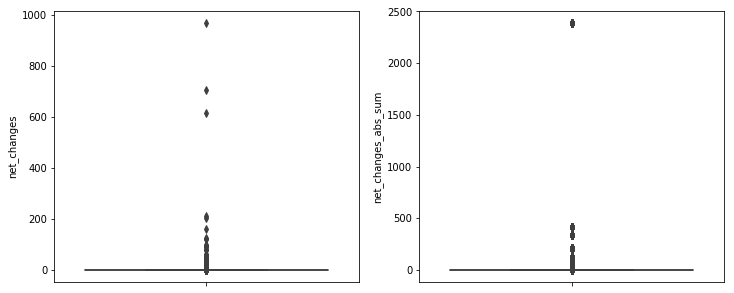

In [26] used 16.8516 MiB RAM in 1.09s, peaked 44.46 MiB above current, total RAM usage 1613.50 MiB


In [26]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

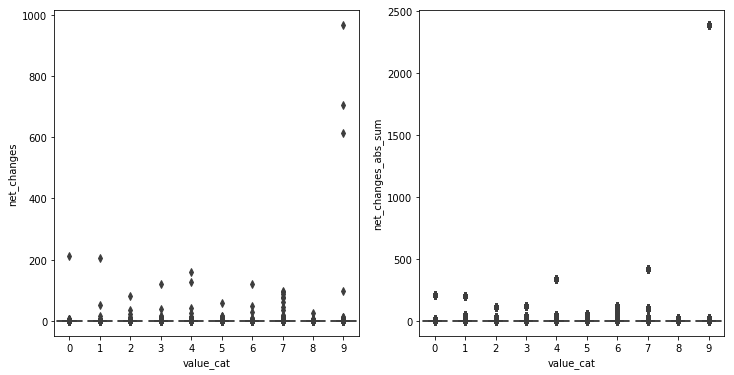

In [27] used 16.8125 MiB RAM in 1.56s, peaked 36.76 MiB above current, total RAM usage 1630.31 MiB


In [27]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

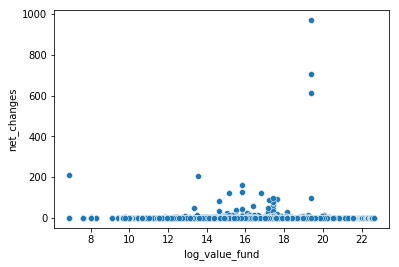

In [28] used 26.8125 MiB RAM in 14.36s, peaked 98.09 MiB above current, total RAM usage 1657.12 MiB


In [28]:
sns.scatterplot(x='log_value_fund', y='net_changes', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

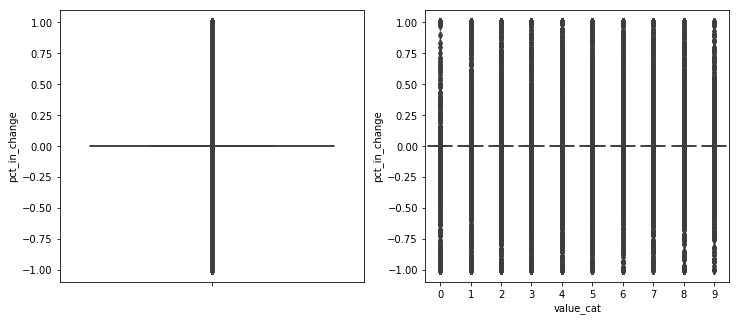

In [29] used 6.3633 MiB RAM in 0.97s, peaked 55.08 MiB above current, total RAM usage 1663.49 MiB


In [29]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

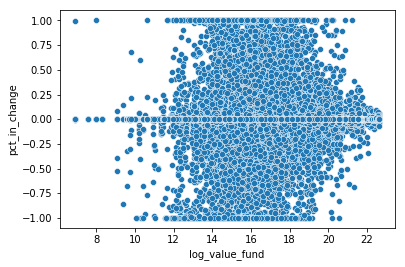

In [30] used 27.5195 MiB RAM in 15.16s, peaked 95.46 MiB above current, total RAM usage 1691.01 MiB


In [30]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', data=final_df);

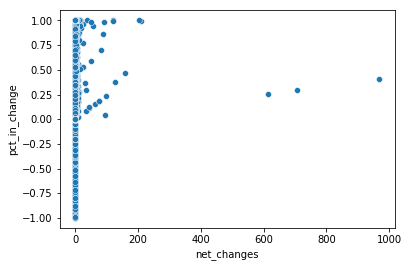

In [31] used 28.7539 MiB RAM in 15.66s, peaked 124.26 MiB above current, total RAM usage 1719.76 MiB


In [31]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [32]:
for lag in range(1, num_lags + 1):

    final_df['ticker_share_lag' + '_' + str(lag)] = final_df.ticker_share.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

In [32] used 87.5820 MiB RAM in 1.59s, peaked 2.74 MiB above current, total RAM usage 1807.34 MiB


In [33]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
2033,2017Q1,1197853,0.000000
357,2016Q1,1568679,NaN
3725,2017Q4,1632548,1.386828
1020,2016Q3,1029160,0.742692
475,2016Q2,712534,1.034793


In [33] used -31.1914 MiB RAM in 10.93s, peaked 2390.43 MiB above current, total RAM usage 1776.15 MiB


In [34]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
2537,2017Q2,1316507,0.828528
1228,2016Q3,1511739,1.647684
5249,2018Q3,1662888,NaN
1763,2016Q4,1580101,NaN
808,2016Q2,1549408,NaN


In [34] used 0.0977 MiB RAM in 9.89s, peaked 2390.54 MiB above current, total RAM usage 1776.25 MiB


In [35]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
424,2016Q1,1632512,NaN
2402,2017Q2,884314,1.399260
2174,2017Q1,1510099,2.000000
2685,2017Q2,1544773,1.986934
871,2016Q2,1605522,NaN


In [35] used 0.1016 MiB RAM in 9.22s, peaked 2390.56 MiB above current, total RAM usage 1776.35 MiB


Теперь HHI.

In [36]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,3520,0.096988
1,2016Q1,7789,0.692333
2,2016Q1,9631,0.149250
3,2016Q1,35442,0.273944
4,2016Q1,44365,0.122040


In [36] used 0.2695 MiB RAM in 8.45s, peaked 2390.56 MiB above current, total RAM usage 1776.62 MiB


Теперь посмотрю на их распределение.

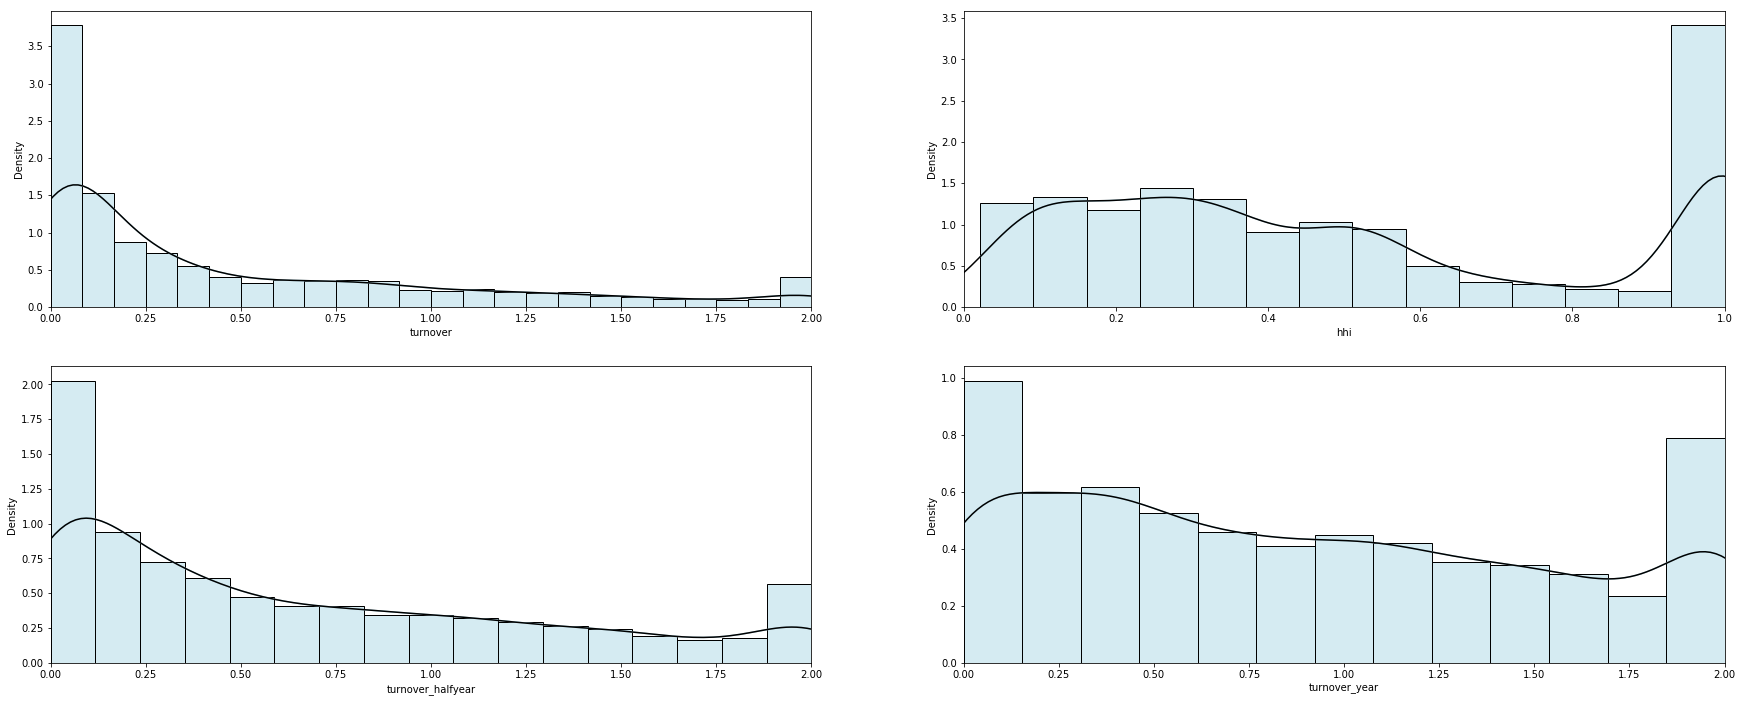

In [37] used 7.2344 MiB RAM in 0.85s, peaked 7.10 MiB above current, total RAM usage 1783.86 MiB


In [37]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

# axs[0, 0].hist(turnover.turnover, density=True, bins=50);
# axs[0, 0].set_title('Distribution of Turnover');
# axs[0, 0].set(xlabel='Turnover', ylabel='Density');
sns.histplot(turnover.turnover, kde=True, stat='density', color='lightblue', ax=axs[0,0]);
sns.kdeplot(turnover.turnover, color='black', ax=axs[0,0]);
axs[0, 0].set_xlim(0, 2);

# axs[0, 1].hist(hhi.hhi, density=True, bins=50);
# axs[0, 1].set_title('Distribution of HHI');
# axs[0, 1].set(xlabel='HHI', ylabel='Density');
sns.histplot(hhi.hhi, kde=True, stat='density', color='lightblue', ax=axs[0,1]);
sns.kdeplot(hhi.hhi, color='black', ax=axs[0,1]);
axs[0, 1].set_xlim(0, 1);

# axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
# axs[1, 0].set_title('Distribution of Turnover');
# axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');
sns.histplot(turnover_halfyear.turnover_halfyear, kde=True, stat='density', color='lightblue', ax=axs[1,0]);
sns.kdeplot(turnover_halfyear.turnover_halfyear, color='black', ax=axs[1,0]);
axs[1, 0].set_xlim(0, 2);

sns.histplot(turnover_year.turnover_year, kde=True, stat='density', color='lightblue', ax=axs[1,1]);
sns.kdeplot(turnover_year.turnover_year, color='black', ax=axs[1,1]);
axs[1, 1].set_xlim(0, 2);

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

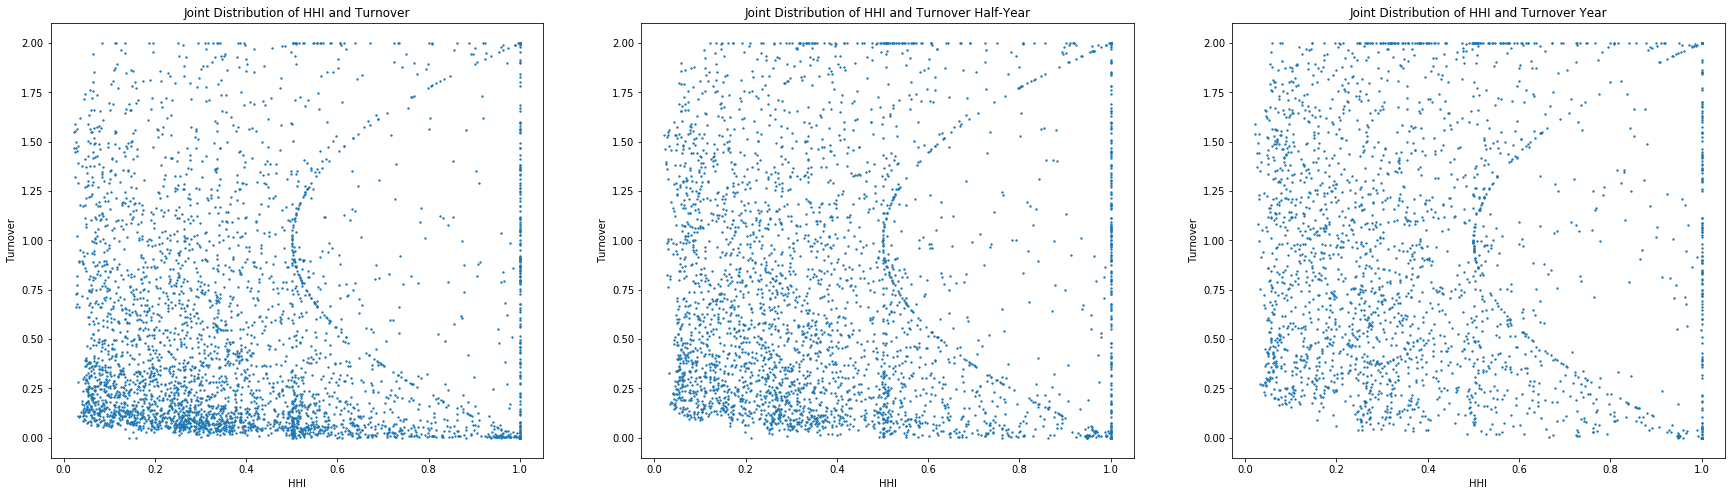

In [38] used 5.5938 MiB RAM in 0.52s, peaked 4.43 MiB above current, total RAM usage 1789.45 MiB


In [38]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Ещё в правых частях графиков можно наблюдать некую параболу. Она словно принимает минимальное значение при $Turnover=1$, равное $HHI=0.5$. Кроме того, при $Turnover \in \{0, 2\}$ она принимает значение $HHI=1$. Такой параболе соответствует уравнение:

$$HHI = \frac{{Turnover}^2}{2} - {Turnover} + 1$$ 

Я утверждаю, что такая парабола соответствует тем фондам, у которых в предыдущем периоде были активы только одного тикера, а в текущем добавился ещё один. Этот "один тикер" можно с погрешностью воспринимать как несколько тикеров, среди которых купленные активы одного из них значительно превышают остальные.

Итак, введем обозначения.

Пусть $x_{1,t_{0}} \gt 0$ - доля единственного тикера тикера в предыдущем периоде, $x_{1,t_{1}}=1$ - его же доля в текущем периоде, а $x_{2,t_{1}} \gt 0$ - доля купленного в текущем периоде нового тикера.
Тогда:
$$HHI = x_{1,t_{1}}^2 + x_{2,t_{1}}^2,$$
$$Turnover = |x_{1,t_{1}} - x_{1,t_{0}}| + |x_{2,t_{1}}| = 1 - x_{1,t_{1}} + x_{2,t_{1}}.$$
Кроме того, заметим, что
$$x_{1,t_{1}} + x_{2,t_{1}} = 1.$$

Теперь рассмотрим правую часть равенства (уравнение параболы). Раскроем его, подставив формулу Turnover.

$$ \frac{{(1 - x_{1,t_{1}} + x_{2,t_{1}})}^2}{2} - (1 - x_{1,t_{1}} + x_{2,t_{1}}) + 1 =
\frac{{(1  +  2 \cdot (x_{2,t_{1}} - x_{1,t_{1}}) + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} - 1 + x_{1,t_{1}} - x_{2,t_{1}} + 1 =
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} + (x_{2,t_{1}} - x_{1,t_{1}}) - (x_{2,t_{1}} - x_{1,t_{1}}) = 
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} = \frac{1}{2} + \frac{{(x_{2,t_{1}} - x_{1,t_{1}})^2}}{2} 
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2 - 2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2} $$

Теперь подставим преобразованную часть в исходное равенство, подставив формулу HHI.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 = \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}$$

Теперь домножим обе части равенства на два, приведем подобные слагаемые и перенесем все переменные в одну часть. Тогда получится следующее.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 + 2 \cdot x_{2,t_{1}} \cdot x_{1,t_{1}} = 1 $$

Заметим, что слева у нас полный квадрат, поэтому

$$ (x_{2,t_{1}} + x_{1,t_{1}})^2 = 1. $$

Но мы тогда возвращаемся к начальному условию, которое говорит, что $x_{1,t_{1}} + x_{2,t_{1}} = 1$. Это значит, что данная зависимость верна для любого фонда, которые перешел от инвестирования в один тикер к инвестированию в два тикера. $\blacksquare$

Из этого следует, что эта парабола совершенно естественная, в отличие от фондов, которые торгуют двумя тикерами, и никакого контроля осуществлять не следует.

Теперь, когда я получил один из наиболее существенных теоретических результатов этой работы, я позволю себе избавиться от аутлаеров в зависимых переменных и изменении цены. После этого я заново прогоню тот участок кода, в котором отразятся изменения этого этапа обработки.

In [39]:
final_df = final_df[final_df.net_changes.lt(np.nanquantile(final_df.net_changes, .99975)) & 
                   final_df.price_change_quarter.lt(np.nanquantile(final_df.price_change_quarter, .995)) & 
                   final_df.price_change_year.lt(np.nanquantile(final_df.price_change_year, .975))]

In [39] used -831.3906 MiB RAM in 0.66s, peaked 1178.00 MiB above current, total RAM usage 958.06 MiB


#### Повтор работы

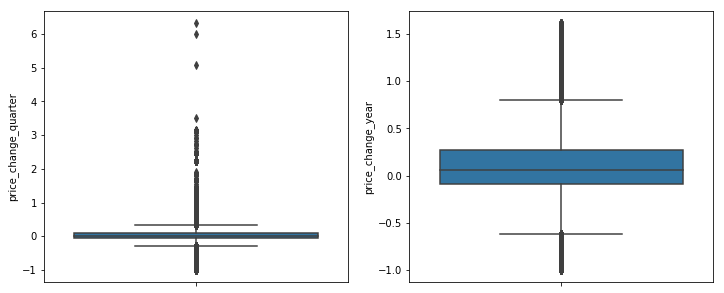

In [40] used 10.8984 MiB RAM in 0.66s, peaked 1.17 MiB above current, total RAM usage 968.96 MiB


In [40]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

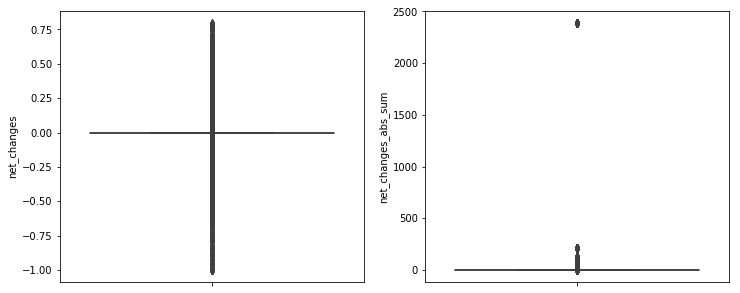

In [41] used 5.0742 MiB RAM in 0.53s, peaked 7.84 MiB above current, total RAM usage 974.03 MiB


In [41]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

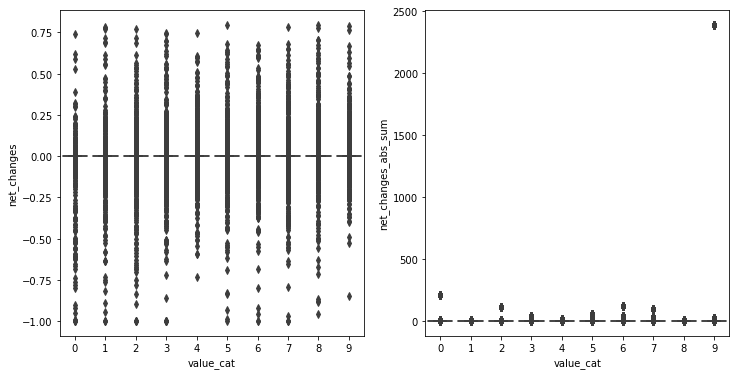

In [42] used 37.0430 MiB RAM in 0.84s, peaked 12.50 MiB above current, total RAM usage 1011.07 MiB


In [42]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

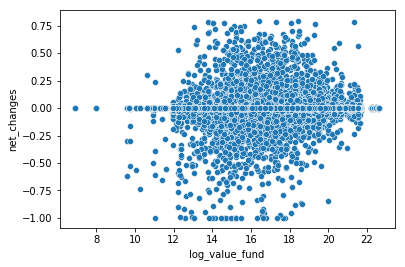

In [43] used 17.5078 MiB RAM in 6.62s, peaked 38.14 MiB above current, total RAM usage 1028.58 MiB


In [43]:
sns.scatterplot(x='log_value_fund', y='net_changes', data=final_df);

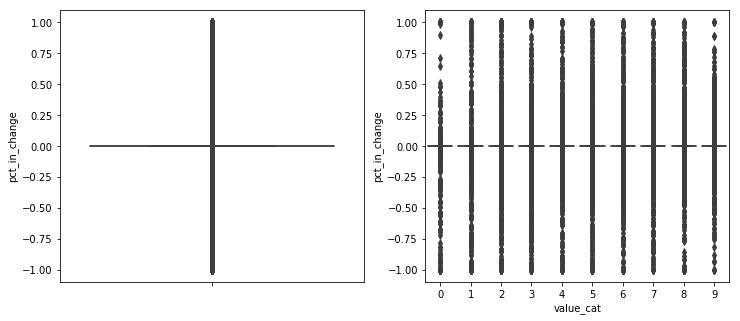

In [44] used 2.0547 MiB RAM in 0.61s, peaked 16.84 MiB above current, total RAM usage 1030.64 MiB


In [44]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

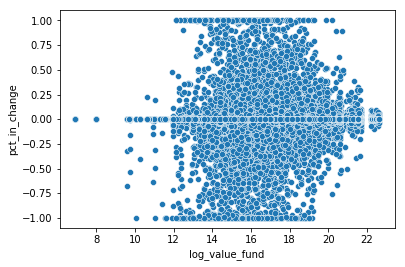

In [45] used 18.0234 MiB RAM in 6.65s, peaked 37.68 MiB above current, total RAM usage 1048.66 MiB


In [45]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', data=final_df);

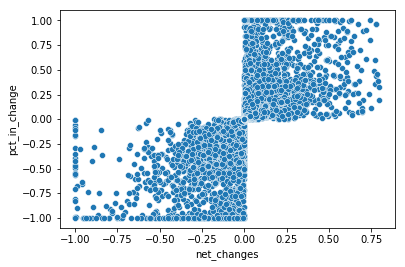

In [46] used 13.5547 MiB RAM in 6.68s, peaked 38.01 MiB above current, total RAM usage 1062.21 MiB


In [46]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

In [47]:
corr = final_df[['shares', 'ticker_share', 'shares_lag_1', 'net_changes', 'pct_in_change',
       'pct_in_change_1', 'net_changes_1', 'pct_in_change_2', 'net_changes_2',
       'pct_in_change_3', 'net_changes_3', 'pct_in_change_4', 'net_changes_4',
       'mode_close', 'net_changes_abs_sum', 'ticker_share_lag_1',
       'ticker_share_lag_2', 'ticker_share_lag_4']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,shares,ticker_share,shares_lag_1,net_changes,pct_in_change,pct_in_change_1,net_changes_1,pct_in_change_2,net_changes_2,pct_in_change_3,net_changes_3,pct_in_change_4,net_changes_4,mode_close,net_changes_abs_sum,ticker_share_lag_1,ticker_share_lag_2,ticker_share_lag_4
shares,1.00,1.00,0.82,0.16,0.16,0.07,0.07,0.06,0.06,0.06,0.06,0.05,0.05,0.13,0.04,0.82,0.76,0.69
ticker_share,1.00,1.00,0.82,0.16,0.16,0.07,0.07,0.06,0.06,0.06,0.06,0.05,0.05,0.13,0.04,0.82,0.76,0.69
shares_lag_1,0.82,0.82,1.00,-0.19,-0.19,0.18,0.18,0.07,0.07,0.07,0.07,0.05,0.05,0.13,0.04,1.00,0.82,0.72
net_changes,0.16,0.16,-0.19,1.00,1.00,-0.03,-0.03,0.05,0.05,0.03,0.03,0.04,0.04,-0.01,0.00,-0.19,-0.09,-0.05
pct_in_change,0.16,0.16,-0.19,1.00,1.00,-0.03,-0.03,0.05,0.05,0.03,0.03,0.04,0.04,-0.01,0.00,-0.19,-0.09,-0.05
pct_in_change_1,0.07,0.07,0.18,-0.03,-0.03,1.00,1.00,-0.03,-0.03,0.04,0.04,0.03,0.03,-0.00,-0.00,0.18,-0.18,-0.05
net_changes_1,0.07,0.07,0.18,-0.03,-0.03,1.00,1.00,-0.03,-0.03,0.04,0.04,0.03,0.03,-0.00,-0.00,0.18,-0.18,-0.05
pct_in_change_2,0.06,0.06,0.07,0.05,0.05,-0.03,-0.03,1.00,1.00,-0.04,-0.04,0.05,0.05,-0.00,0.00,0.07,0.19,-0.07
net_changes_2,0.06,0.06,0.07,0.05,0.05,-0.03,-0.03,1.00,1.00,-0.04,-0.04,0.05,0.04,-0.00,0.00,0.07,0.19,-0.07
pct_in_change_3,0.06,0.06,0.07,0.03,0.03,0.04,0.04,-0.04,-0.04,1.00,1.00,-0.03,-0.03,-0.00,0.00,0.07,0.09,-0.16


In [47] used 14.3789 MiB RAM in 11.83s, peaked 399.42 MiB above current, total RAM usage 1076.59 MiB


In [48]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
944,2017Q3,1390003,0.102293
1561,2018Q1,883782,0.322907
1999,2018Q2,1029160,0.181735
2529,2018Q3,1442891,0.286042
1780,2018Q1,1512173,1.012209


In [48] used 0.0977 MiB RAM in 2.71s, peaked 702.19 MiB above current, total RAM usage 1076.69 MiB


In [49]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
27,2017Q1,825293,0.102032
1532,2018Q1,108572,0.317090
192,2017Q1,1387869,1.477547
504,2017Q2,1161722,0.051178
290,2017Q1,1560808,0.288246


In [49] used -0.0078 MiB RAM in 2.72s, peaked 702.20 MiB above current, total RAM usage 1076.68 MiB


In [50]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
859,2017Q3,1106832,1.432843
1390,2017Q4,1532351,1.105212
488,2017Q2,1112325,0.335091
894,2017Q3,1283718,0.569485
1359,2017Q4,1478735,1.181987


In [50] used 0.1641 MiB RAM in 2.75s, peaked 702.18 MiB above current, total RAM usage 1076.85 MiB


In [51]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2017Q1,3520,0.092359
1,2017Q1,7789,0.401607
2,2017Q1,9631,0.061941
3,2017Q1,35442,0.233778
4,2017Q1,44365,0.115213


In [51] used 0.0078 MiB RAM in 2.34s, peaked 702.19 MiB above current, total RAM usage 1076.86 MiB


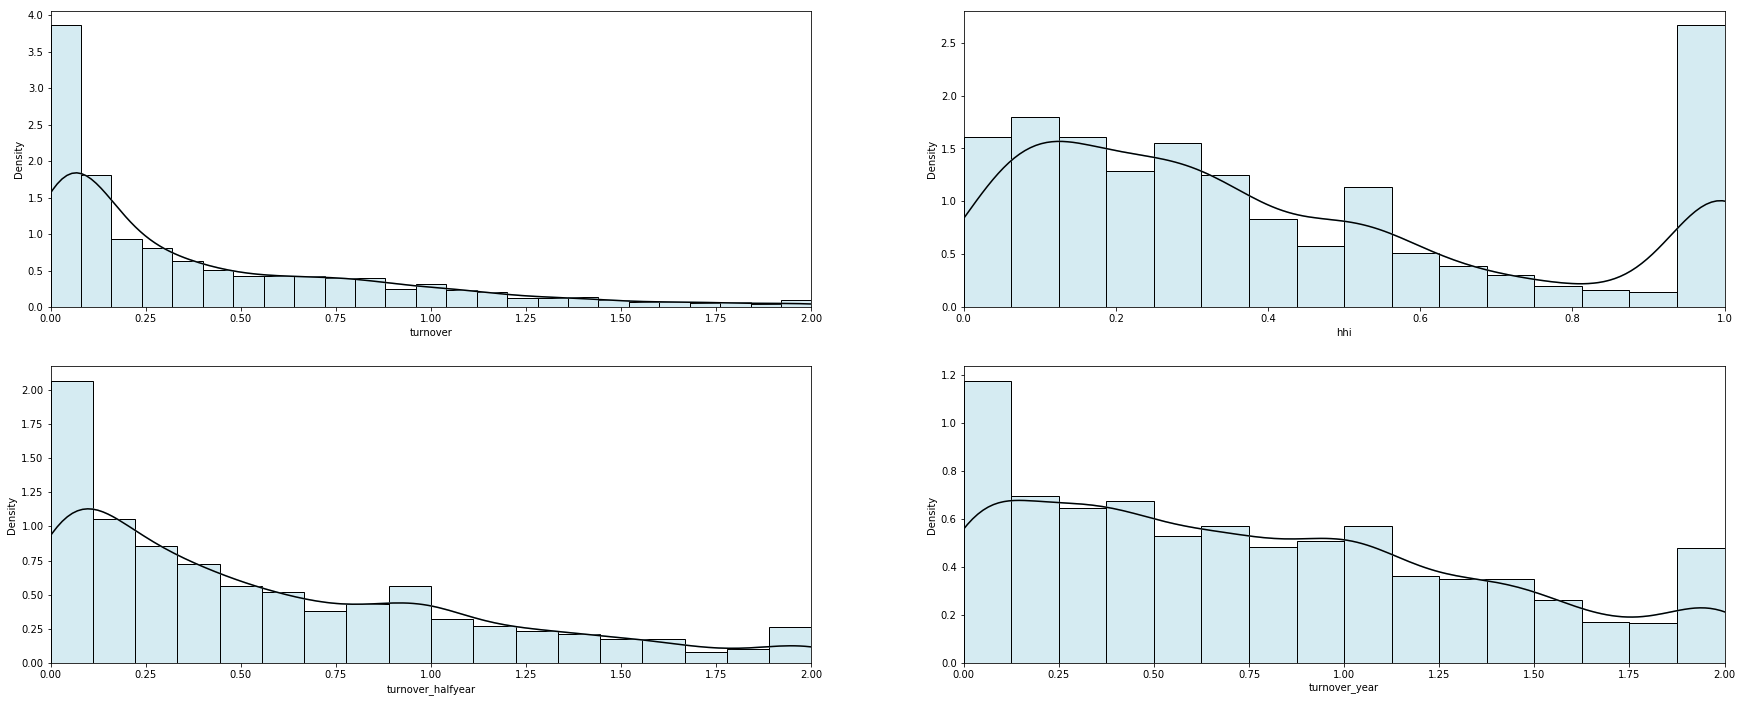

In [52] used 6.2031 MiB RAM in 0.79s, peaked 2.34 MiB above current, total RAM usage 1083.06 MiB


In [52]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

# axs[0, 0].hist(turnover.turnover, density=True, bins=50);
# axs[0, 0].set_title('Distribution of Turnover');
# axs[0, 0].set(xlabel='Turnover', ylabel='Density');
sns.histplot(turnover.turnover, kde=True, stat='density', color='lightblue', ax=axs[0,0]);
sns.kdeplot(turnover.turnover, color='black', ax=axs[0,0]);
axs[0, 0].set_xlim(0, 2);

# axs[0, 1].hist(hhi.hhi, density=True, bins=50);
# axs[0, 1].set_title('Distribution of HHI');
# axs[0, 1].set(xlabel='HHI', ylabel='Density');
sns.histplot(hhi.hhi, kde=True, stat='density', color='lightblue', ax=axs[0,1]);
sns.kdeplot(hhi.hhi, color='black', ax=axs[0,1]);
axs[0, 1].set_xlim(0, 1);

# axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
# axs[1, 0].set_title('Distribution of Turnover');
# axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');
sns.histplot(turnover_halfyear.turnover_halfyear, kde=True, stat='density', color='lightblue', ax=axs[1,0]);
sns.kdeplot(turnover_halfyear.turnover_halfyear, color='black', ax=axs[1,0]);
axs[1, 0].set_xlim(0, 2);

sns.histplot(turnover_year.turnover_year, kde=True, stat='density', color='lightblue', ax=axs[1,1]);
sns.kdeplot(turnover_year.turnover_year, color='black', ax=axs[1,1]);
axs[1, 1].set_xlim(0, 2);

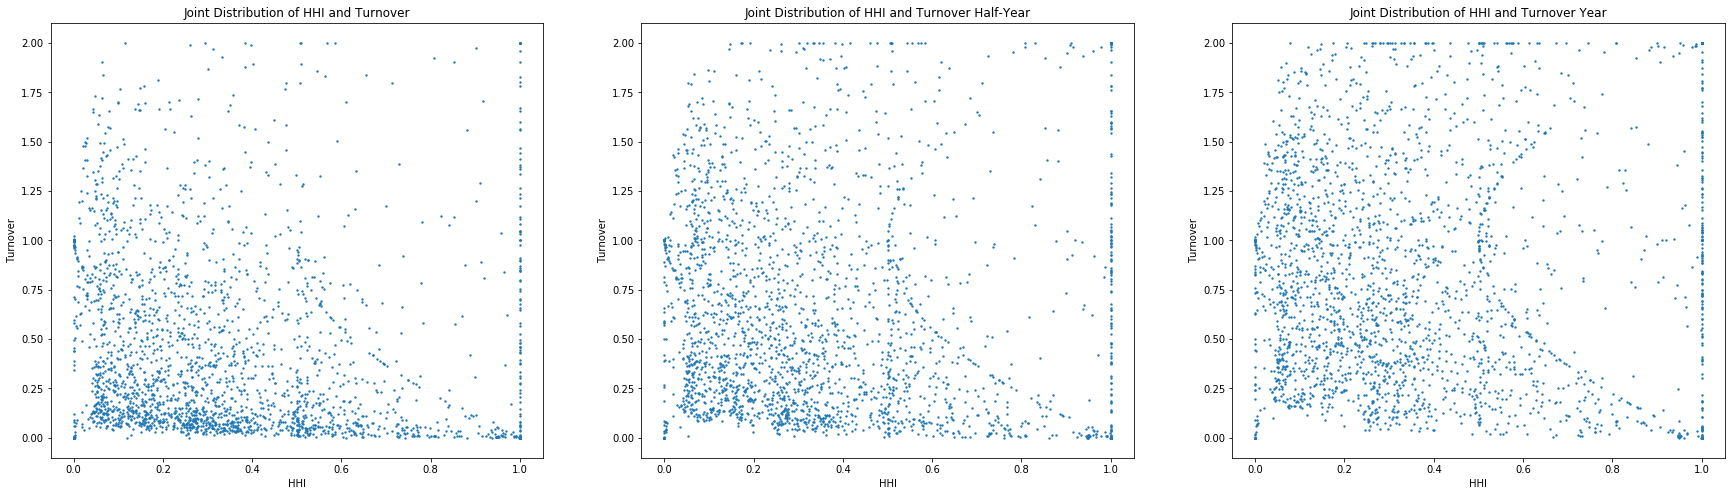

In [53] used 4.6953 MiB RAM in 0.50s, peaked 4.20 MiB above current, total RAM usage 1087.75 MiB


In [53]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

После удаления аутлаеров моя парабола уже почти не заметна.

Добавляю переменные на основе наблюдений.

In [54]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [54] used -5.6992 MiB RAM in 3.03s, peaked 353.66 MiB above current, total RAM usage 1082.05 MiB


In [55]:
for lag in range(1, num_lags + 1):

    final_df['turnover_lag' + '_' + str(lag)] = final_df.turnover.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

final_df['mean_tvr'] = final_df.turnover / 4

for lag in range(1, num_lags):

    final_df['mean_tvr'] += final_df['turnover_lag' + '_' + str(lag)] / 4

In [55] used 32.5430 MiB RAM in 0.62s, peaked 6.43 MiB above current, total RAM usage 1114.60 MiB


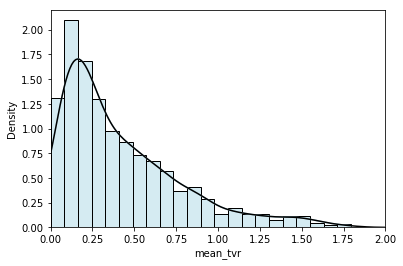

In [56] used 0.5742 MiB RAM in 0.28s, peaked 0.00 MiB above current, total RAM usage 1115.17 MiB


In [56]:
sns.histplot(final_df.mean_tvr.unique(), kde=True, stat='density', color='lightblue');
sns.kdeplot(final_df.mean_tvr.unique(), color='black');
pl.xlim(0, 2);
pl.xlabel('mean_tvr');

In [57]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, -1), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['mean_tvr_cat'] = pd.cut(final_df.mean_tvr, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))

In [57] used 3.2695 MiB RAM in 0.23s, peaked 4.82 MiB above current, total RAM usage 1118.44 MiB


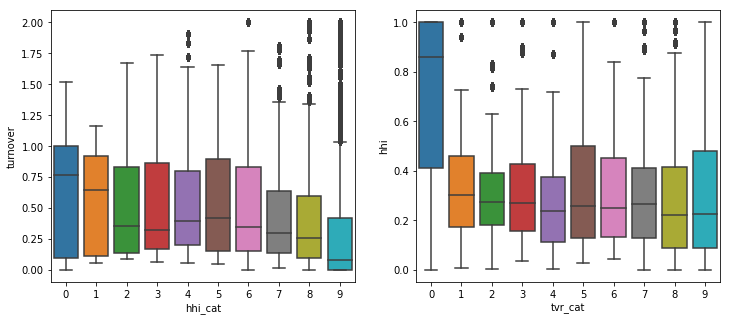

In [58] used 26.3398 MiB RAM in 0.74s, peaked 26.63 MiB above current, total RAM usage 1144.78 MiB


In [58]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

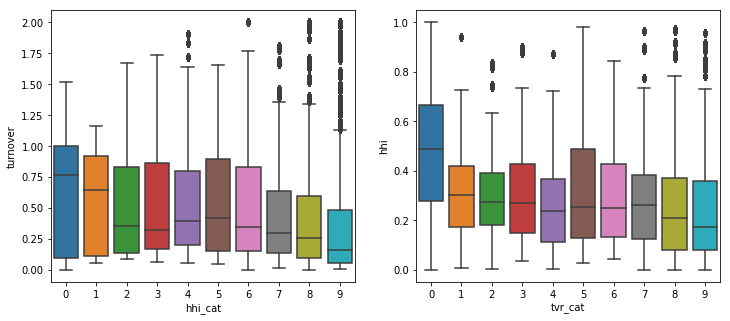

In [59] used 358.4492 MiB RAM in 1.28s, peaked 66.54 MiB above current, total RAM usage 1503.23 MiB


In [59]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

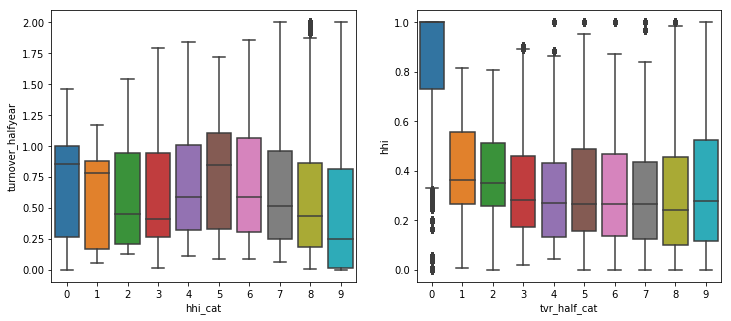

In [60] used 19.1680 MiB RAM in 0.65s, peaked 5.96 MiB above current, total RAM usage 1522.40 MiB


In [60]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

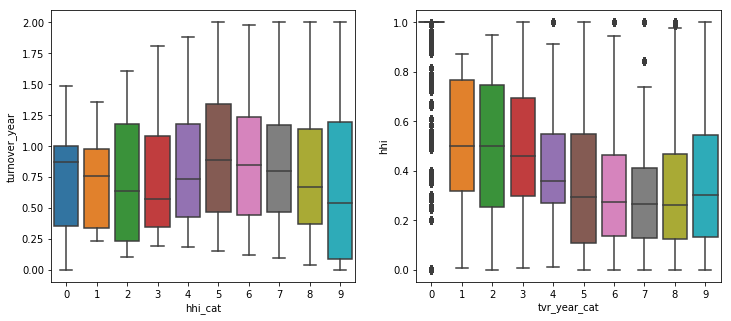

In [61] used 9.0430 MiB RAM in 0.66s, peaked 13.27 MiB above current, total RAM usage 1531.44 MiB


In [61]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

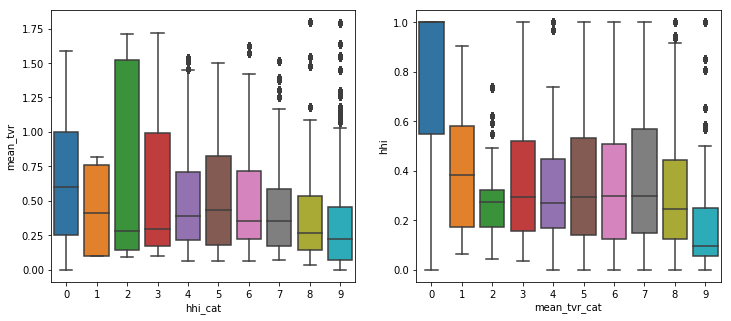

In [62] used 7.4727 MiB RAM in 0.57s, peaked 4.76 MiB above current, total RAM usage 1538.91 MiB


In [62]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='mean_tvr', data=final_df, ax=ax[0]);
sns.boxplot(x='mean_tvr_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

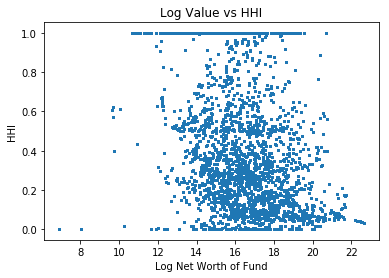

In [63] used 12.9258 MiB RAM in 5.47s, peaked 1.61 MiB above current, total RAM usage 1551.84 MiB


In [63]:
pl.scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
pl.title('Log Value vs HHI');
pl.xlabel('Log Net Worth of Fund');
pl.ylabel('HHI');

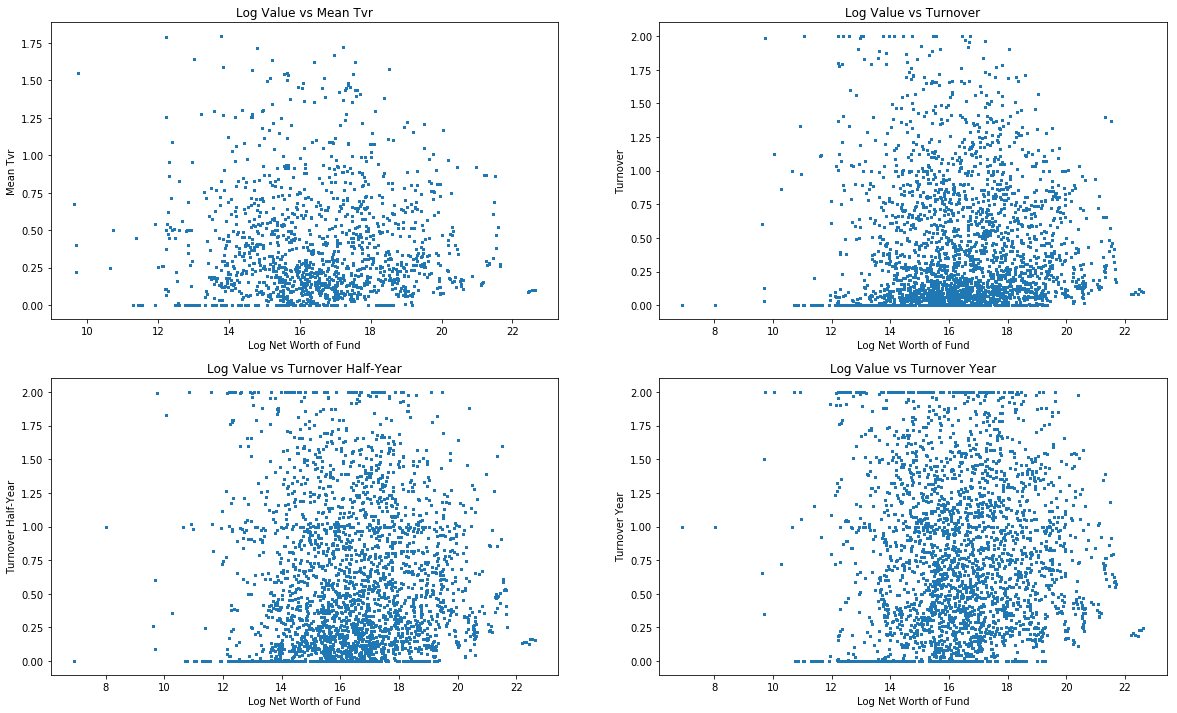

In [64] used 47.4531 MiB RAM in 18.82s, peaked 4.80 MiB above current, total RAM usage 1599.29 MiB


In [64]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.mean_tvr, s=1.8);
axs[0, 0].set_title('Log Value vs Mean Tvr');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='Mean Tvr');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

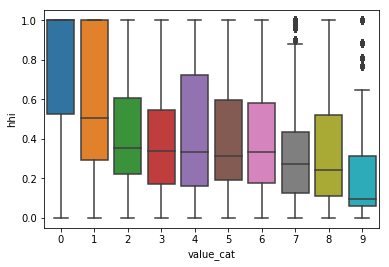

In [65] used -16.1406 MiB RAM in 0.41s, peaked 22.59 MiB above current, total RAM usage 1583.15 MiB


In [65]:
sns.boxplot(x='value_cat', y='hhi', data=final_df);

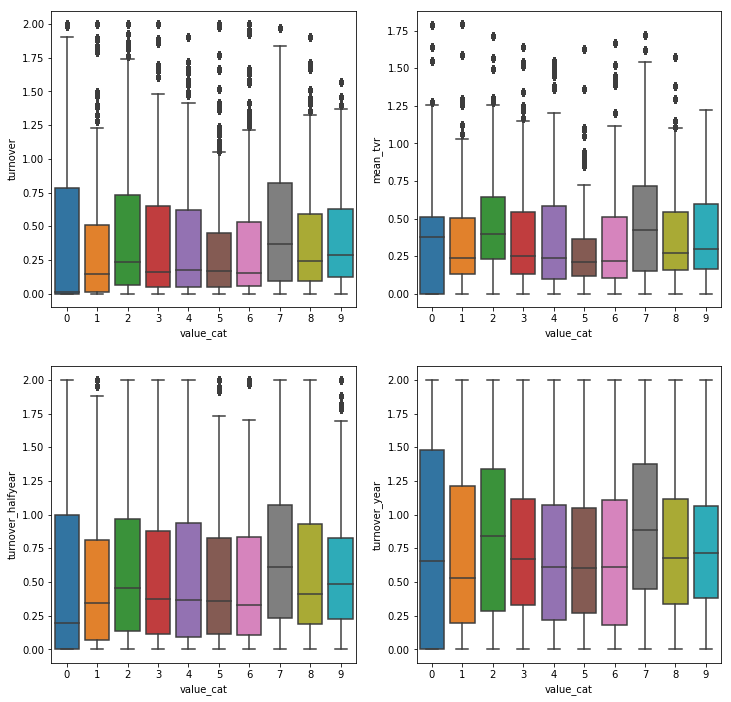

In [66] used 6.7383 MiB RAM in 1.14s, peaked 14.87 MiB above current, total RAM usage 1589.89 MiB


In [66]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='mean_tvr', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

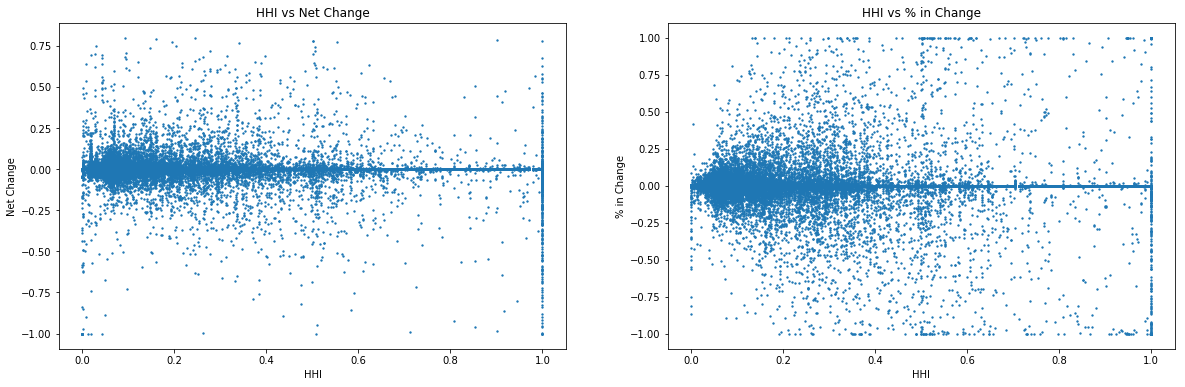

In [67] used 32.5586 MiB RAM in 10.87s, peaked 2.12 MiB above current, total RAM usage 1622.45 MiB


In [67]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0].set_title('HHI vs Net Change');
axs[0].set(xlabel='HHI', ylabel='Net Change');

axs[1].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[1].set_title('HHI vs % in Change');
axs[1].set(xlabel='HHI', ylabel='% in Change');

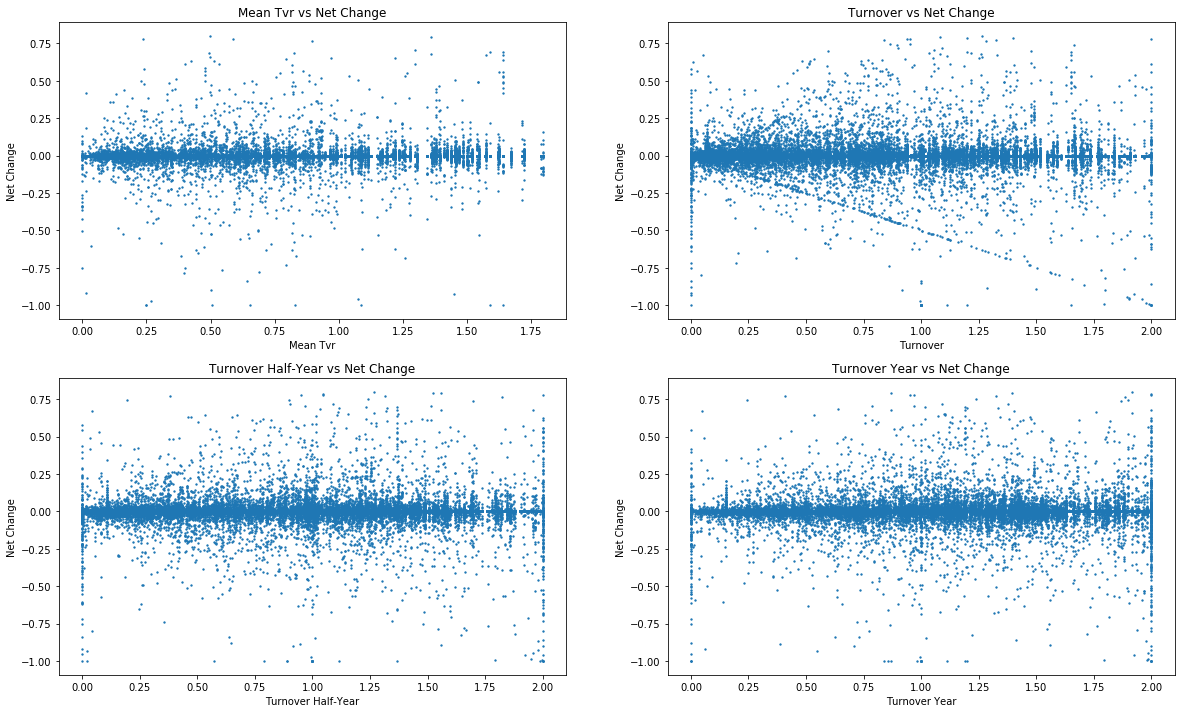

In [68] used 50.0508 MiB RAM in 19.17s, peaked 4.41 MiB above current, total RAM usage 1672.50 MiB


In [68]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.mean_tvr,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('Mean Tvr vs Net Change');
axs[0, 0].set(xlabel='Mean Tvr', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

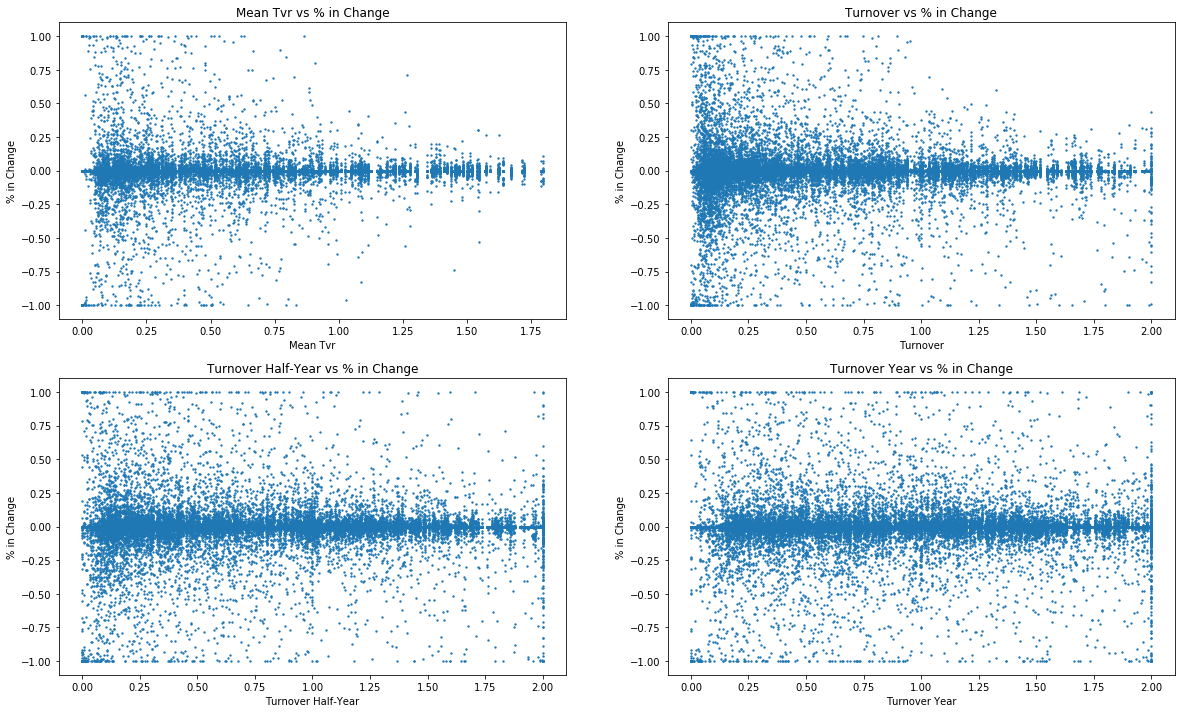

In [69] used 49.8008 MiB RAM in 21.63s, peaked 3.83 MiB above current, total RAM usage 1722.30 MiB


In [69]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.mean_tvr,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('Mean Tvr vs % in Change');
axs[0, 0].set(xlabel='Mean Tvr', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [70]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).apply(lambda x: x[x.shares != 0].ticker_id.nunique()).reset_index()
pos_count.rename(columns={0: 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2017Q1,3520,19
1,2017Q1,7789,7
2,2017Q1,9631,42
3,2017Q1,35442,5
4,2017Q1,44365,46


In [70] used -10.3672 MiB RAM in 5.92s, peaked 836.85 MiB above current, total RAM usage 1711.93 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [71]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [71] used -18.1289 MiB RAM in 2.33s, peaked 703.13 MiB above current, total RAM usage 1693.80 MiB


Теперь посмотрим на распределение количества позиций в фонде.

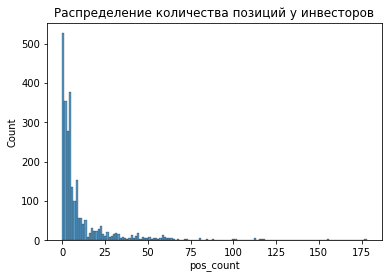

In [72] used 1.8789 MiB RAM in 0.41s, peaked 0.00 MiB above current, total RAM usage 1695.68 MiB


In [72]:
sns.histplot(pos_count.pos_count);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [73]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [-1, 30, 200, 500, 1000, 2000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '>2000'])

In [73] used 0.0234 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 1695.71 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

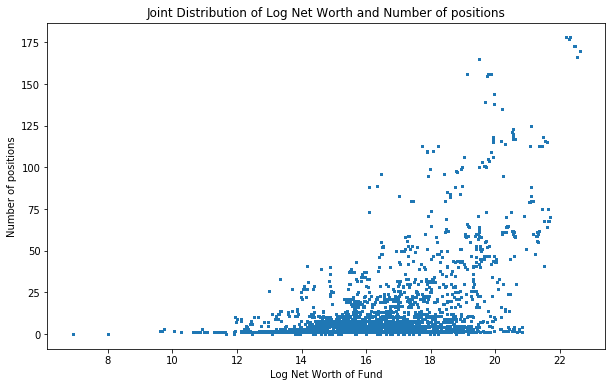

In [74] used 13.1719 MiB RAM in 5.71s, peaked 1.10 MiB above current, total RAM usage 1708.88 MiB


In [74]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions');
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

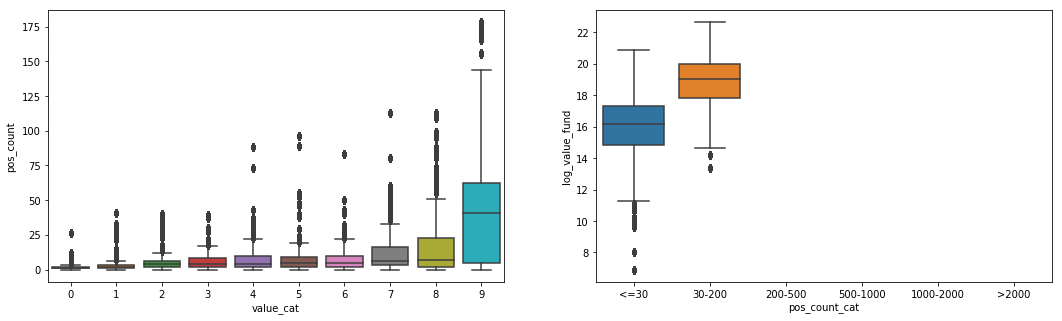

In [75] used 44.5703 MiB RAM in 0.86s, peaked 5.19 MiB above current, total RAM usage 1753.45 MiB


In [75]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

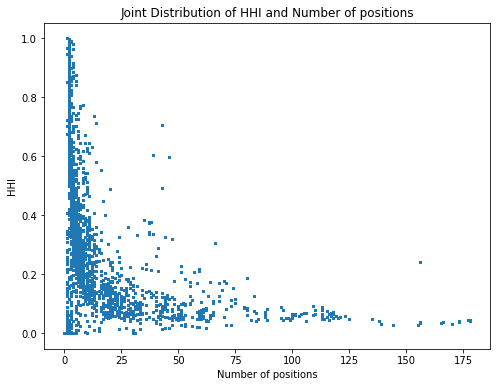

In [76] used 16.2773 MiB RAM in 5.88s, peaked 0.24 MiB above current, total RAM usage 1769.73 MiB


In [76]:
fig, axs = pl.subplots(1, 1, figsize=(8, 6));

axs.scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs.set_title('Joint Distribution of HHI and Number of positions');
axs.set(xlabel='Number of positions', ylabel='HHI');

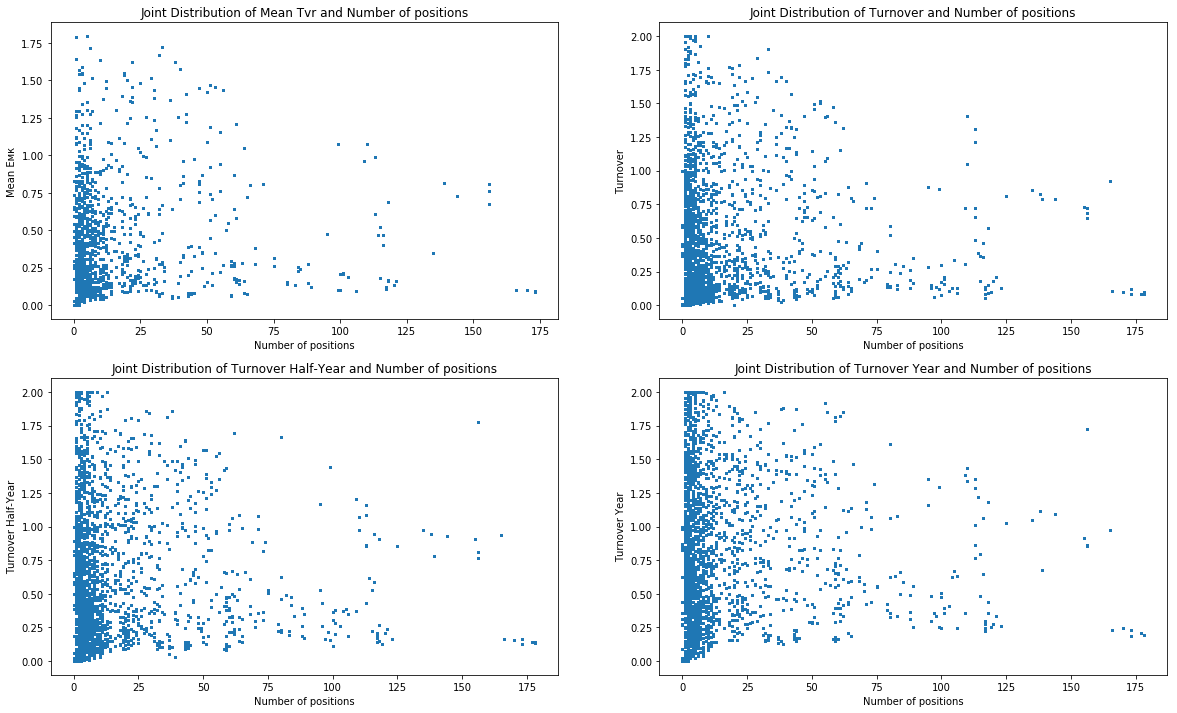

In [77] used 49.1836 MiB RAM in 19.76s, peaked 4.72 MiB above current, total RAM usage 1818.91 MiB


In [77]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.mean_tvr, s=1.8);
axs[0, 0].set_title('Joint Distribution of Mean Tvr and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='Mean Емк');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

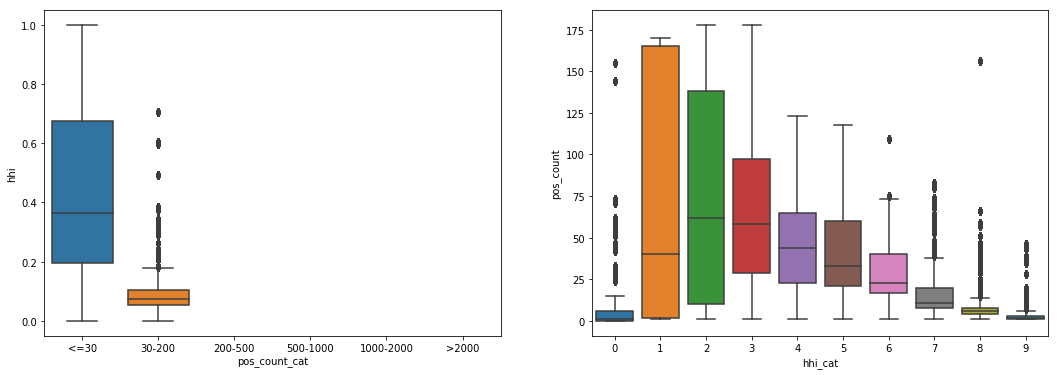

In [78] used 11.0664 MiB RAM in 0.82s, peaked 5.45 MiB above current, total RAM usage 1829.98 MiB


In [78]:
fig, ax = pl.subplots(1, 2, figsize=(18, 6));

sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0]);
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[1]);

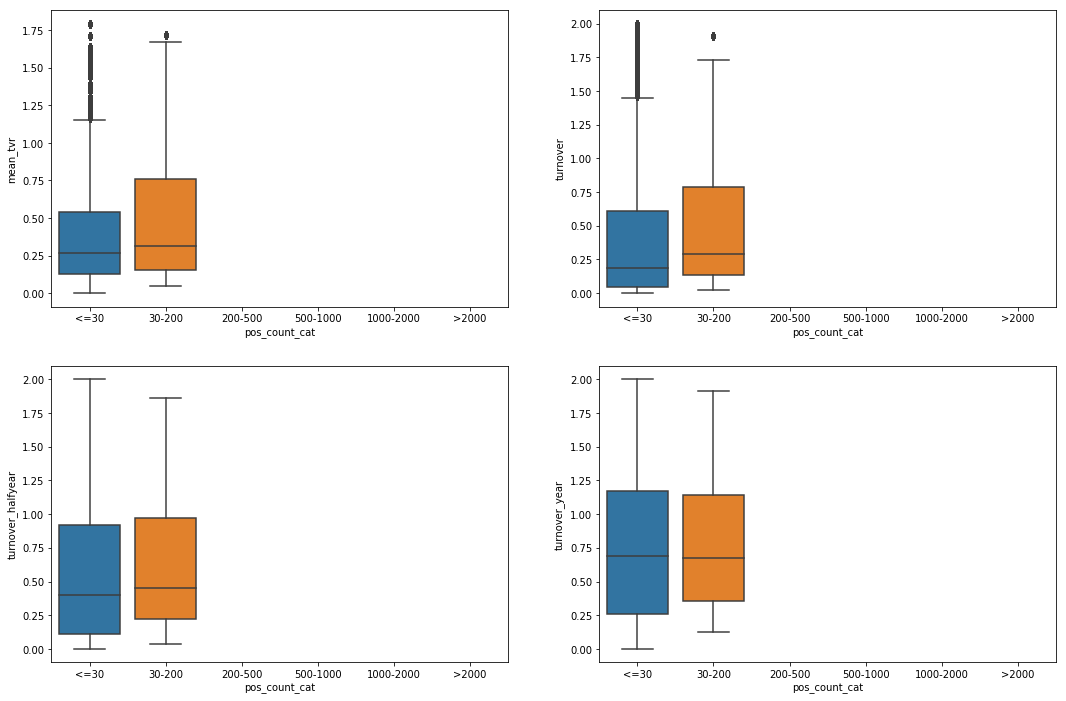

In [79] used 6.8125 MiB RAM in 1.10s, peaked 18.23 MiB above current, total RAM usage 1836.79 MiB


In [79]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='mean_tvr', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

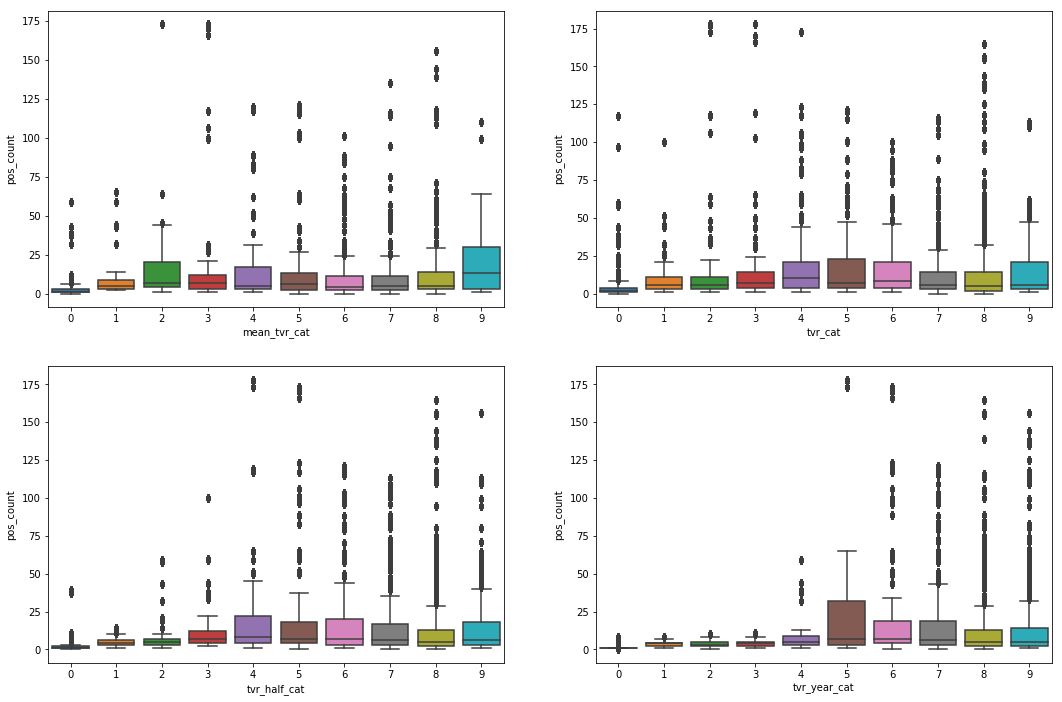

In [80] used 33.6172 MiB RAM in 2.01s, peaked 10.40 MiB above current, total RAM usage 1870.41 MiB


In [80]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='mean_tvr_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

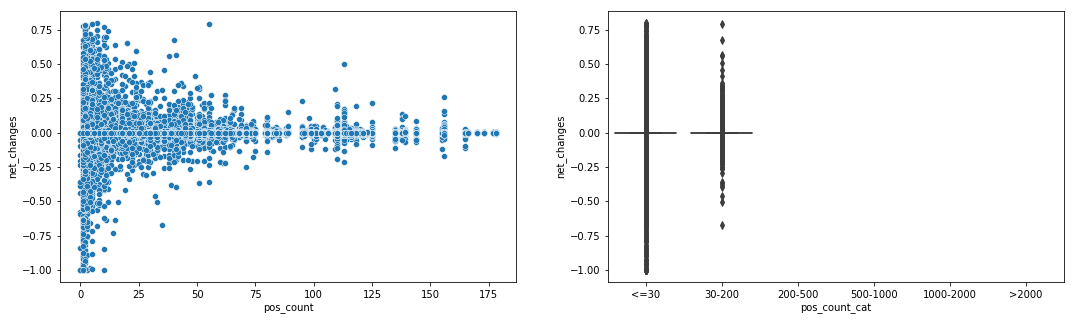

In [81] used 15.4570 MiB RAM in 7.65s, peaked 42.53 MiB above current, total RAM usage 1885.86 MiB


In [81]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

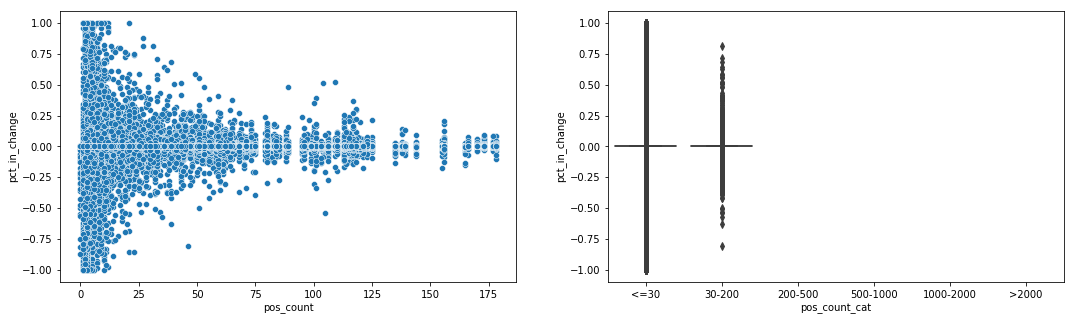

In [82] used 14.8555 MiB RAM in 8.39s, peaked 36.73 MiB above current, total RAM usage 1900.72 MiB


In [82]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [83]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'mean_tvr', 'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,mean_tvr,hhi,pos_count
log_value_fund,1.00,0.14,0.13,0.09,0.05,0.03,-0.36,0.42
net_changes_abs_sum,0.14,1.00,0.84,0.69,0.54,0.72,-0.41,0.18
turnover,0.13,0.84,1.00,0.77,0.61,0.76,-0.44,0.35
turnover_halfyear,0.09,0.69,0.77,1.00,0.75,0.81,-0.32,0.26
turnover_year,0.05,0.54,0.61,0.75,1.00,0.80,-0.19,0.19
mean_tvr,0.03,0.72,0.76,0.81,0.80,1.00,-0.31,0.20
hhi,-0.36,-0.41,-0.44,-0.32,-0.19,-0.31,1.00,-0.70
pos_count,0.42,0.18,0.35,0.26,0.19,0.20,-0.70,1.00


In [83] used -0.0547 MiB RAM in 2.93s, peaked 570.66 MiB above current, total RAM usage 1900.66 MiB


Добавление средних изменений зависимых переменных.

In [84]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

mean_pct_in_change_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_pos_count.rename(columns={'pct_in_change': 'mean_pct_in_change_by_pos_count'}, inplace=True)

mean_pct_in_change_by_turnover = final_df.groupby(['ticker_id', 'period', 'tvr_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_turnover.rename(columns={'pct_in_change': 'mean_pct_in_change_by_turnover'}, inplace=True)

mean_pct_in_change_by_hhi = final_df.groupby(['ticker_id', 'period', 'hhi_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_hhi.rename(columns={'pct_in_change': 'mean_pct_in_change_by_hhi'}, inplace=True)



mean_net_changes = final_df.groupby(['ticker_id', 'period'])['net_changes'].mean().reset_index()
mean_net_changes.rename(columns={'net_changes': 'mean_net_changes'}, inplace=True)

mean_net_changes_by_cik = final_df.groupby(['cik', 'period'])['net_changes'].mean().reset_index()
mean_net_changes_by_cik.rename(columns={'net_changes': 'mean_net_changes_by_cik'}, inplace=True)

mean_net_changes_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_value.rename(columns={'net_changes': 'mean_net_changes_by_value'}, inplace=True)

mean_net_changes_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_pos_count.rename(columns={'net_changes': 'mean_net_changes_by_pos_count'}, inplace=True)

mean_net_changes_by_turnover = final_df.groupby(['ticker_id', 'period', 'tvr_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_turnover.rename(columns={'net_changes': 'mean_net_changes_by_turnover'}, inplace=True)

mean_net_changes_by_hhi = final_df.groupby(['ticker_id', 'period', 'hhi_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_hhi.rename(columns={'net_changes': 'mean_net_changes_by_hhi'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_turnover, on=['ticker_id', 'period', 'tvr_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_hhi, on=['ticker_id', 'period', 'hhi_cat'],
                                                                  how='left', suffixes=(False, False))


final_df = final_df.merge(mean_net_changes, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_turnover, on=['ticker_id', 'period', 'tvr_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_hhi, on=['ticker_id', 'period', 'hhi_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()
tickers_count_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat'])\
                                                            .count().reset_index()
tickers_count_by_turnover = final_df.groupby(['ticker_id', 'period', 'tvr_cat'])\
                                                            .count().reset_index()
tickers_count_by_hhi = final_df.groupby(['ticker_id', 'period', 'hhi_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)
tickers_count_by_pos_count.rename(columns={'shares': 'tickers_count_by_pos_count'}, inplace=True)
tickers_count_by_turnover.rename(columns={'shares': 'tickers_count_by_turnover'}, inplace=True)
tickers_count_by_hhi.rename(columns={'shares': 'tickers_count_by_hhi'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_pos_count[['ticker_id', 'period', 'pos_count_cat', 'tickers_count_by_pos_count']], 
                                                                        on=['ticker_id', 'period', 'pos_count_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_turnover[['ticker_id', 'period', 'tvr_cat', 'tickers_count_by_turnover']], 
                                                                        on=['ticker_id', 'period', 'tvr_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_hhi[['ticker_id', 'period', 'hhi_cat', 'tickers_count_by_hhi']], 
                                                                        on=['ticker_id', 'period', 'hhi_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_pct_in_change_by_pos_count'] -= final_df.pct_in_change.div(final_df.tickers_count_by_pos_count, axis=0).values
final_df['mean_pct_in_change_by_turnover'] -= final_df.pct_in_change.div(final_df.tickers_count_by_turnover, axis=0).values
final_df['mean_pct_in_change_by_hhi'] -= final_df.pct_in_change.div(final_df.tickers_count_by_hhi, axis=0).values

final_df['mean_net_changes'] -= final_df.net_changes.div(final_df.tickers_count, axis=0).values
final_df['mean_net_changes_by_cik'] -= final_df.net_changes.div(final_df.pos_count, axis=0).values
final_df['mean_net_changes_by_value'] -= final_df.net_changes.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_net_changes_by_pos_count'] -= final_df.net_changes.div(final_df.tickers_count_by_pos_count, axis=0).values
final_df['mean_net_changes_by_turnover'] -= final_df.net_changes.div(final_df.tickers_count_by_turnover, axis=0).values
final_df['mean_net_changes_by_hhi'] -= final_df.net_changes.div(final_df.tickers_count_by_hhi, axis=0).values

Wall time: 24 s
In [84] used -391.6133 MiB RAM in 24.11s, peaked 842.88 MiB above current, total RAM usage 1509.05 MiB


In [85]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2017Q1,780,44772000.0,3.306970e+10,0.001354
1,2017Q1,1993,19150000.0,3.306970e+10,0.000579
2,2017Q1,2299,3886000.0,3.306970e+10,0.000118
3,2017Q1,2658,13920000.0,3.306970e+10,0.000421
4,2017Q1,3061,141909000.0,3.306970e+10,0.004291
5,2017Q1,3122,7766000.0,3.306970e+10,0.000235
6,2017Q1,5016,198000.0,3.306970e+10,0.000006
7,2017Q1,5047,5086000.0,3.306970e+10,0.000154
8,2017Q1,5357,68303000.0,3.306970e+10,0.002065
9,2017Q1,5836,258000.0,3.306970e+10,0.000008


In [85] used 50.1172 MiB RAM in 2.02s, peaked 502.48 MiB above current, total RAM usage 1559.17 MiB


<h2> Макро-индикаторы </h2>

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [86]:
import pandas_datareader as wb

In [86] used 0.4727 MiB RAM in 0.39s, peaked 0.00 MiB above current, total RAM usage 1559.64 MiB


In [87]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [87] used 6.4258 MiB RAM in 7.08s, peaked 1.05 MiB above current, total RAM usage 1566.07 MiB


In [88]:
vix = wb.DataReader(['VIXCLS'], 'fred', start=2012).resample('Q-DEC').mean() / 100
vix.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
vix.DATE = vix.DATE.dt.to_period('Q')

In [88] used 0.5508 MiB RAM in 0.36s, peaked 0.00 MiB above current, total RAM usage 1566.62 MiB


In [89]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [89] used 0.0781 MiB RAM in 0.34s, peaked 0.00 MiB above current, total RAM usage 1566.70 MiB


In [90]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [90] used 0.0352 MiB RAM in 0.33s, peaked 0.00 MiB above current, total RAM usage 1566.73 MiB


In [91]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(vix, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 3.99 s
In [91] used 19.0234 MiB RAM in 4.10s, peaked 808.41 MiB above current, total RAM usage 1585.75 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [92]:
%%time

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

features = final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp', 'mode_close',
               'cik', 'period', 'ticker_id', 'shares', 'market_value', 'close',
               '_object', 'market_value_fund', 'quarter_sum', 'object', 'market_value_fund_lag_1',
               'diff_value_fund_lag_1', 'market_value_fund_lag_2', 'diff_value_fund_lag_2',
               'market_value_fund_lag_3', 'diff_value_fund_lag_3', 'market_value_fund_lag_4', 'diff_value_fund_lag_4',
               'close_lag_1', 'close_lag_4', 'shares_lag_1', 'net_changes_abs_sum',
               'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4',
               'turnover_lag_1', 'turnover_lag_2', 'turnover_lag_3', 'turnover_lag_4', 'market_value_ticker'], axis=1)
del final_df

# features = final_df.copy()
features = features.replace([np.inf, -np.inf], np.nan).dropna(subset=['net_changes', 'pct_in_change'])

Wall time: 1.13 s
In [92] used -237.6172 MiB RAM in 1.24s, peaked 714.31 MiB above current, total RAM usage 1348.14 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [93]:
import statsmodels.api as sm

In [93] used 10.2305 MiB RAM in 0.91s, peaked 0.00 MiB above current, total RAM usage 1358.37 MiB


In [94]:
data_common = features[features.ticker_share.gt(0) & ~features.enter].drop(['hhi_cat',  'value_cat', 'tvr_cat',
                                            'tvr_half_cat', 'tvr_year_cat','mean_tvr_cat', 'pos_count_cat'], axis=1).fillna(0)

In [94] used 17.5195 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 1375.89 MiB


In [95]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year', 'mean_tvr',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count',
       'mean_pct_in_change_by_turnover', 'mean_pct_in_change_by_hhi', 
       'tickers_count', 'tickers_count_by_value', 'tickers_count_by_pos_count',
       'tickers_count_by_turnover', 'tickers_count_by_hhi', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
       'DGS10', 'DFF', 'UNRATE', 'VIXCLS', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [95] used 10.1172 MiB RAM in 0.14s, peaked 8.10 MiB above current, total RAM usage 1386.00 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [96]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1373.
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:27:50   Log-Likelihood:                 27393.
No. Observations:               28677   AIC:                        -5.470e+04
Df Residuals:                   28636   BIC:                        -5.437e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0278      0.032      0.869      0.385      -0.035       0.090
log_value_fund                   6.923e-05      0.000      0.146      0.884      -0.001       0.001
price_change_quarter               -0.0158      0.004     -4.134      0.000      -0.023      -0.008
price_change_year                  -0.0028      0.002     -1.372      0.170      -0.007       0.001
diff_value_fund_rank_lag_1          0.0311      0.002     18.906      0.000       0.028       0.034
diff_value_fund_rank_lag_2          0.0040      0.002      2.416      0.016       0.001       0.007
diff_value_fund_rank_lag_3          0.0003      0.002      0.177      0.860      -0.003       0.004
diff_value_fund_rank_lag_4         -0.0004      0.002     -0.211      0.833      -0.004       0.003
ticker_share                        0.0446      0.032      1.396      0.163      -0.018       0.107
pct_in_change_1                     0.0443      0.003     13.359      0.000       0.038       0.051
pct_in_change_2                     0.0169      0.003      4.902      0.000       0.010       0.024
pct_in_change_3                     0.0269      0.004      7.610      0.000       0.020       0.034
pct_in_change_4                     0.0083      0.004      2.093      0.036       0.001       0.016
turnover                           -0.0024      0.003     -0.842      0.400      -0.008       0.003
turnover_halfyear                   0.0003      0.003      0.123      0.902      -0.005       0.006
turnover_year                       0.0041      0.002      1.982      0.047    4.57e-05       0.008
mean_tvr                            0.0003      0.003      0.106      0.915      -0.005       0.006
hhi                                -0.0011      0.011     -0.102      0.919      -0.022       0.020
hhi_eq_1                            0.0239      0.008      3.177      0.001       0.009       0.039
pos_count                       -3.331e-05   2.34e-05     -1.424      0.155   -7.92e-05    1.25e-05
mean_pct_in_change                  0.2088      0.159      1.317      0.188      -0.102       0.520
mean_pct_in_change_by_cik          -1.3635      0.006   -225.127      0.000      -1.375      -1.352
mean_pct_in_change_by_value        -0.0838      0.058     -1.451      0.147      -0.197       0.029
mean_pct_in_change_by_pos_count     0.2605      0.123      2.126      0.034       0.020       0.501
mean_pct_in_change_by_turnover      0.0709      0.044      1.620      0.105      -0.015       0.157
mean_pct_in_change_by_hhi           0.1265      0.064      1.977      0.048       0.001       0.252
tickers_count                    -1.16e-05   7.01e-05     -0.165      0.869      -0.000       0.000
tickers_count_by_value              0.0003      0.000      1.719      0.086   -3.72

In [96] used 18.1367 MiB RAM in 0.28s, peaked 0.00 MiB above current, total RAM usage 1404.14 MiB


In [97]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)
np.square(delta_1).sum(), np.square(y - y.mean()).sum()

(248.51178104624952, 725.0599089242296)

In [97] used -0.0078 MiB RAM in 0.12s, peaked 0.01 MiB above current, total RAM usage 1404.13 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

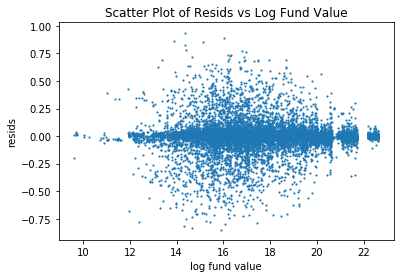

In [98] used 1.0312 MiB RAM in 0.47s, peaked 0.00 MiB above current, total RAM usage 1405.16 MiB


In [98]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

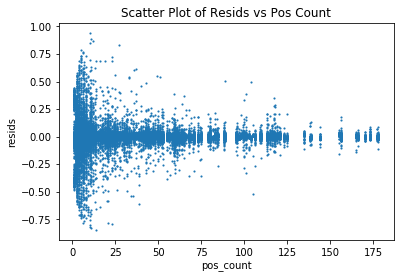

In [99] used 0.5273 MiB RAM in 0.39s, peaked 0.00 MiB above current, total RAM usage 1405.69 MiB


In [99]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

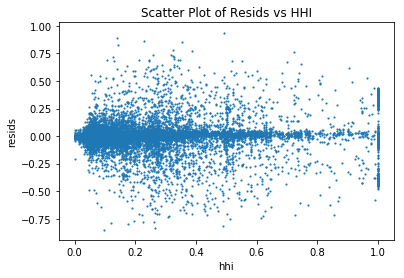

In [100] used 0.9922 MiB RAM in 0.39s, peaked 0.00 MiB above current, total RAM usage 1406.68 MiB


In [100]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

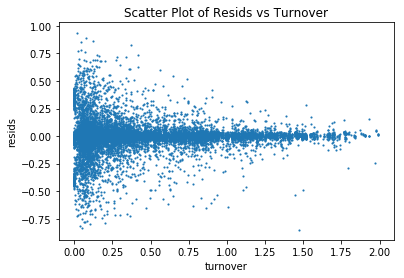

In [101] used 0.9844 MiB RAM in 0.41s, peaked 0.00 MiB above current, total RAM usage 1407.67 MiB


In [101]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

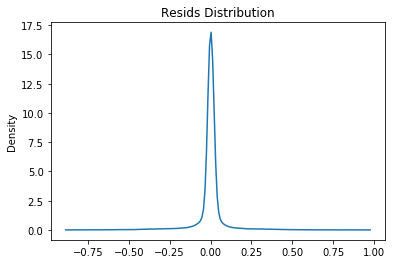

In [102] used 2.7227 MiB RAM in 0.43s, peaked 0.00 MiB above current, total RAM usage 1410.39 MiB


In [102]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 2

In [103]:
y = data_common['net_changes']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year', 'mean_tvr',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_net_changes', 'mean_net_changes_by_cik',
       'mean_net_changes_by_value', 'mean_net_changes_by_pos_count',
       'mean_net_changes_by_turnover', 'mean_net_changes_by_hhi', 
       'tickers_count', 'tickers_count_by_value', 'tickers_count_by_pos_count',
       'tickers_count_by_turnover', 'tickers_count_by_hhi', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
       'DGS10', 'DFF', 'UNRATE', 'VIXCLS', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [103] used 9.6602 MiB RAM in 0.14s, peaked 5.57 MiB above current, total RAM usage 1420.05 MiB


In [104]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     984.2
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:27:53   Log-Likelihood:                 56856.
No. Observations:               28677   AIC:                        -1.136e+05
Df Residuals:                   28636   BIC:                        -1.133e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0289      0.011      2.521      0.012       0.006       0.051
log_value_fund                -7.261e-05      0.000     -0.427      0.669      -0.000       0.000
price_change_quarter             -0.0075      0.001     -5.518      0.000      -0.010      -0.005
price_change_year                -0.0002      0.001     -0.322      0.748      -0.002       0.001
diff_value_fund_rank_lag_1        0.0132      0.001     22.396      0.000       0.012       0.014
diff_value_fund_rank_lag_2        0.0003      0.001      0.487      0.626      -0.001       0.001
diff_value_fund_rank_lag_3       -0.0007      0.001     -1.213      0.225      -0.002       0.000
diff_value_fund_rank_lag_4       -0.0006      0.001     -1.071      0.284      -0.002       0.001
ticker_share                      0.0605      0.011      5.294      0.000       0.038       0.083
net_changes_1                 -2.291e-05   2.46e-05     -0.931      0.352   -7.11e-05    2.53e-05
net_changes_2                 -5.491e-05   2.46e-05     -2.229      0.026      -0.000   -6.62e-06
net_changes_3                 -3.093e-05   2.47e-05     -1.253      0.210   -7.93e-05    1.75e-05
net_changes_4                 -5.265e-06   2.47e-05     -0.213      0.831   -5.37e-05    4.31e-05
turnover                         -0.0030      0.001     -2.916      0.004      -0.005      -0.001
turnover_halfyear                 0.0016      0.001      1.621      0.105      -0.000       0.004
turnover_year                     0.0020      0.001      2.711      0.007       0.001       0.003
mean_tvr                          0.0022      0.001      2.242      0.025       0.000       0.004
hhi                              -0.0110      0.004     -2.867      0.004      -0.018      -0.003
hhi_eq_1                          0.0019      0.003      0.690      0.490      -0.003       0.007
pos_count                     -3.021e-05   8.37e-06     -3.609      0.000   -4.66e-05   -1.38e-05
mean_net_changes                  0.1672      0.132      1.271      0.204      -0.091       0.425
mean_net_changes_by_cik          -1.3850      0.007   -192.876      0.000      -1.399      -1.371
mean_net_changes_by_value        -0.0038      0.041     -0.092      0.927      -0.084       0.077
mean_net_changes_by_pos_count     0.0613      0.074      0.823      0.411      -0.085       0.207
mean_net_changes_by_turnover      0.0026      0.050      0.052      0.958      -0.096       0.102
mean_net_changes_by_hhi           0.0114      0.026      0.433      0.665      -0.040       0.063
tickers_count                  1.637e-05   2.52e-05      0.651      0.515   -3.29e-05    6.57e-05
tickers_count_by_value         7.424e-05   5.51e-05      1.348      0.178   -3.37e-05       0.000
tickers_count_by_pos_count    -4.609e-06   2.

In [104] used 9.1797 MiB RAM in 0.22s, peaked 8.70 MiB above current, total RAM usage 1429.23 MiB


In [105]:
delta_2 = y - model_2.predict(X)
np.square(delta_2).sum(), np.square(y - y.mean()).sum()

(31.83860081306391, 75.60834954914196)

In [105] used 0.0039 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1429.23 MiB


### Модель 3

In [106]:
y = features['enter']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year', 'mean_tvr',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_net_changes', 'mean_net_changes_by_cik',
       'mean_net_changes_by_value', 'mean_net_changes_by_pos_count',
       'mean_net_changes_by_turnover', 'mean_net_changes_by_hhi', 
       'tickers_count', 'tickers_count_by_value', 'tickers_count_by_pos_count',
       'tickers_count_by_turnover', 'tickers_count_by_hhi', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
       'DGS10', 'DFF', 'UNRATE', 'VIXCLS', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [106] used 257.6797 MiB RAM in 1.01s, peaked 515.86 MiB above current, total RAM usage 1686.91 MiB


In [107]:
model_3 = sm.Logit(y, X).fit()
print(model_3.summary())

         Current function value: 0.033140
         Iterations: 35


C:\Users\Redmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                  enter   No. Observations:               844320
Model:                          Logit   Df Residuals:                   844280
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Jan 2021   Pseudo R-squ.:                  0.2251
Time:                        22:28:18   Log-Likelihood:                -27981.
converged:                      False   LL-Null:                       -36108.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -209.4158      7.830    -26.745      0.000    -224.763    -194.069
log_value_fund                    0.0252      0.012      2.126      0.034 

In [108]:
from sklearn.metrics import f1_score

f1_score(y, model_3.predict(X) > .5)

0.08487420430433465

In [108] used 0.2227 MiB RAM in 0.59s, peaked 11.98 MiB above current, total RAM usage 1694.09 MiB


### Модель 4

In [109]:
y = features['exit']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year', 'mean_tvr',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_net_changes', 'mean_net_changes_by_cik',
       'mean_net_changes_by_value', 'mean_net_changes_by_pos_count',
       'mean_net_changes_by_turnover', 'mean_net_changes_by_hhi', 
       'tickers_count', 'tickers_count_by_value', 'tickers_count_by_pos_count',
       'tickers_count_by_turnover', 'tickers_count_by_hhi', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
       'DGS10', 'DFF', 'UNRATE', 'VIXCLS', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [109] used 257.6758 MiB RAM in 1.00s, peaked 596.76 MiB above current, total RAM usage 1951.77 MiB


In [110]:
model_4 = sm.Logit(y, X).fit()
print(model_4.summary())

         Current function value: 0.029872
         Iterations: 35


C:\Users\Redmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                   exit   No. Observations:               844320
Model:                          Logit   Df Residuals:                   844280
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Jan 2021   Pseudo R-squ.:                  0.2805
Time:                        22:28:46   Log-Likelihood:                -25221.
converged:                      False   LL-Null:                       -35055.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -96.4188      6.558    -14.702      0.000    -109.273     -83.565
log_value_fund                    0.0980      0.012      8.239      0.000 

In [111]:
f1_score(y, model_4.predict(X) > .5)

0.13486281196713687

In [111] used 0.0195 MiB RAM in 0.50s, peaked 15.86 MiB above current, total RAM usage 1958.26 MiB


### Модель 5

In [125]:
class MulticlassLinearRegression:
    
    def __init__(self):
        self.sum_of_sq = 0
        self.var_y = 0
        self.inter_var_y = 0
        self.df = None
        self.y_col = None
        self.norm=False
        self.num_lags = 0
        self.r2 = 0
        self.inter_r2 = 0
        self.r2_list = []
        self.mean_r2 = 0
        self.pred = []
    
    def regress(self, df):
                
        from sklearn.linear_model import LinearRegression
        
        y = df[self.y_col].values
        X = df.drop(self.y_col, axis=1).values
        
        if self.norm:
            
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X)
            
            X = scaler.transform(X)
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        pred = reg.predict(X)
        self.pred.append(pred)
        
        resid = y - pred
        self.sum_of_sq += np.square(resid).sum()
        
        self.inter_var_y += ((y - y.mean()) ** 2).sum()
        
        if np.allclose(y, y.mean()):
            
            self.r2_list.append(0.0)
        
        else:
            r2 = 1 - (np.square(resid).sum() / ((y - y.mean()) ** 2).sum())
            self.r2_list.append(r2)
            self.mean_r2 += r2 * df.shape[0]
            
            if r2 < 0:
                return True
        
    
    def fit(self, df, y_col, cat_cols, num_lags, lag=False, norm=False):
        self.y_col = y_col
        self.num_lags = num_lags
        self.sum_of_sq = 0
        self.inter_var_y = 0
        self.norm = norm
        
        self.df = df.copy(deep=True)
        self.df['global_cat'] = self.df[cat_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)
        self.df.drop(cat_cols, axis=1, inplace=True)
        
        self.var_y = ((self.df[y_col] - self.df[y_col].mean()) ** 2).sum()
        
        for cat in self.df.global_cat.unique():
            df_slice = self.df[self.df.global_cat.eq(cat)].drop('global_cat', axis=1)
            if lag:
                for i in range(self.num_lags + 1):
                    df_slice_lags = df_slice.copy()
                    for k in range(1, i + 1):
                        df_slice_lags = df_slice_lags[~df_slice_lags[y_col + '_' + str(k)].isna()]
                    if i < self.num_lags:
                        df_slice_lags = df_slice_lags[df_slice_lags[y_col + '_' + str(i + 1)].isna()]
                    for k in range(i + 1, num_lags + 1):
                        df_slice_lags = df_slice_lags.drop([y_col + '_' + str(k)], axis=1)
                    df_slice_lags.fillna(0, inplace=True)
                    if df_slice_lags.shape[0] > 0:
                        if self.regress(df_slice_lags):
#                             print(cat)
                            pass
            else:
                
                df_slice.fillna(0, inplace=True)
                if df_slice.shape[0] > 0:
                    if self.regress(df_slice):
#                         print(cat)
                        pass
                
        self.inter_r2 = 1 - self.sum_of_sq / self.inter_var_y
        self.r2 = 1 - self.sum_of_sq / self.var_y
        self.mean_r2 /= self.df.shape[0]
        
        return self.r2, self.inter_r2, self.mean_r2
    
    def predict(self):
        
        return np.array(self.pred)

In [125] used -101.9648 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1518.37 MiB


Проблема, что все наблюдения зависимой переменной могут быть равны нулю или/и в подгруппе может быть только одно наблюдение.

In [126]:
%%time

data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat',
                                                                     'pos_count_cat', 'mean_tvr_cat', 'net_changes',
                                                                     'net_changes_1', 'net_changes_2', 'net_changes_3',
                                                                     'net_changes_4', 'hhi', 'turnover'], axis=1)

multi1 = MulticlassLinearRegression()

print(multi1.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True))

multi2 = MulticlassLinearRegression()

print(multi2.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False))

multi3 = MulticlassLinearRegression()

print(multi3.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True, True))

multi4 = MulticlassLinearRegression()

print(multi4.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False, True))

(0.8160162340312702, 0.8141376795593999, 0.8472160856549652)
(0.8312885609719838, 0.8300287851906455, 0.8378854293318554)
(0.7806744832480106, 0.778435074090793, 0.8309473346831341)
(0.839944240784363, 0.8387490973472302, 0.8460547516684748)
Wall time: 7.05 s
In [126] used 0.6836 MiB RAM in 7.16s, peaked 2.04 MiB above current, total RAM usage 1519.05 MiB


In [127]:
print(multi1.inter_var_y, multi1.var_y)
print(multi2.inter_var_y, multi2.var_y)
print(multi3.inter_var_y, multi3.var_y)
print(multi4.inter_var_y, multi4.var_y)

717.7315567813387 725.0599089242296
719.6859818489503 725.0599089242296
717.7315567813387 725.0599089242296
719.6859818489503 725.0599089242296
In [127] used 0.0195 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1519.07 MiB


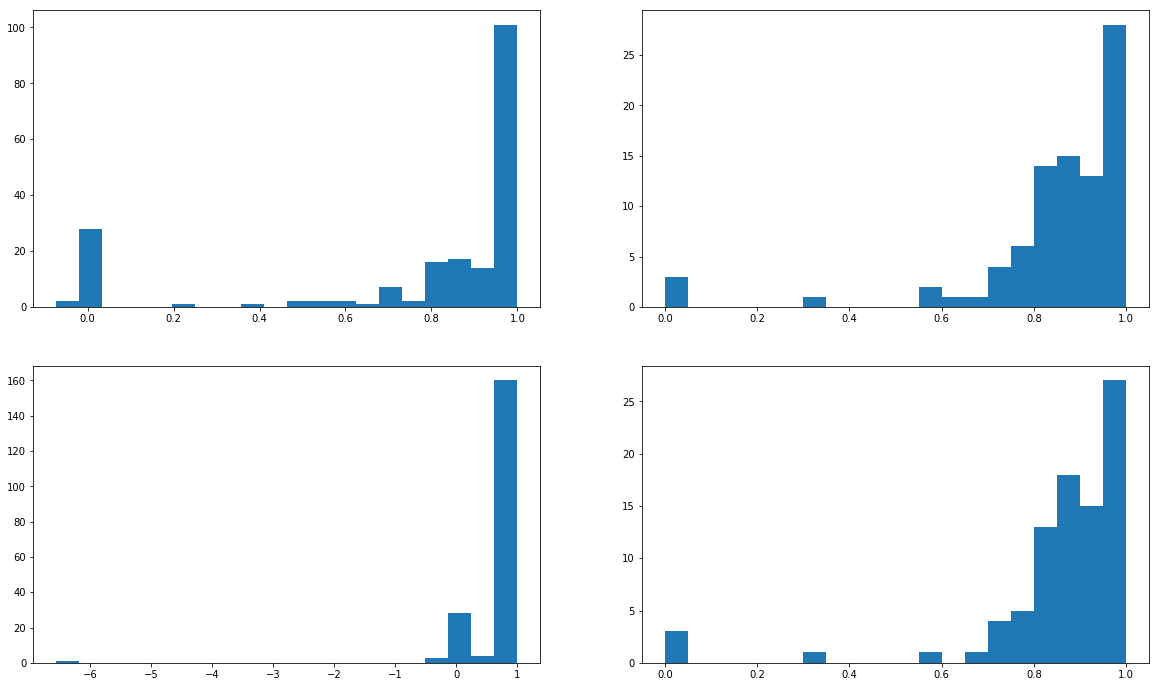

In [128] used 0.2266 MiB RAM in 0.61s, peaked 4.75 MiB above current, total RAM usage 1519.30 MiB


In [128]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].hist(multi1.r2_list, bins=20);

axs[0, 1].hist(multi2.r2_list, bins=20);

axs[1, 0].hist(multi3.r2_list, bins=20);

axs[1, 1].hist(multi4.r2_list, bins=20);

In [129]:
%%time

data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat',
                                                                     'pos_count_cat', 'mean_tvr_cat', 'pct_in_change',
                                                                     'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3',
                                                                     'pct_in_change_4', 'hhi', 'turnover'], axis=1)

multi1 = MulticlassLinearRegression()

print(multi1.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, True))

multi2 = MulticlassLinearRegression()

print(multi2.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, False))

multi3 = MulticlassLinearRegression()

print(multi3.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, True, True))

multi4 = MulticlassLinearRegression()

print(multi4.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, False, True))

(0.8439169225494513, 0.8411784804692432, 0.8419927016708657)
(0.5227451383064347, 0.5163889449492065, 0.5994926154297637)
(0.8002851445549053, 0.7967811928573435, 0.8616627836190439)
(0.8334583926538691, 0.8312403520569454, 0.847178018698519)
Wall time: 6.13 s
In [129] used 0.1602 MiB RAM in 6.23s, peaked 2.20 MiB above current, total RAM usage 1519.46 MiB


In [130]:
print(multi1.inter_var_y, multi1.var_y)
print(multi2.inter_var_y, multi2.var_y)
print(multi3.inter_var_y, multi3.var_y)
print(multi4.inter_var_y, multi4.var_y)

74.30469065812905 75.60834954914196
74.61461443052528 75.60834954914196
74.30469065812905 75.60834954914196
74.61461443052528 75.60834954914196
In [130] used 0.0234 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1519.48 MiB


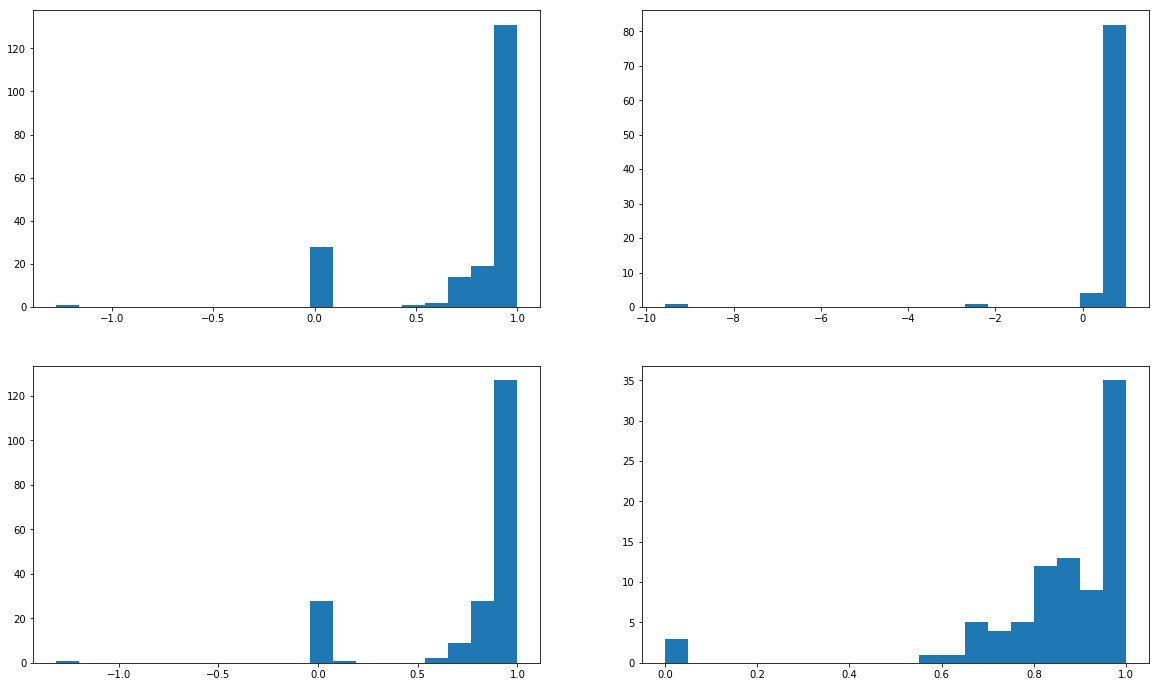

In [131] used 3.0430 MiB RAM in 0.75s, peaked 4.75 MiB above current, total RAM usage 1522.52 MiB


In [131]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].hist(multi1.r2_list, bins=20);

axs[0, 1].hist(multi2.r2_list, bins=20);

axs[1, 0].hist(multi3.r2_list, bins=20);

axs[1, 1].hist(multi4.r2_list, bins=20);

In [132]:
class MulticlassClassification:
    
    def __init__(self):
        self.df = None
        self.y_col = None
        self.norm=False
        self.num_lags = 0
        self.pred = []
        self.actual = []
        
        self.model = None
    
    def regress(self, df):
        
        y = df[self.y_col].values
        X = df.drop(self.y_col, axis=1).values
        
        if len(set(y)) == 1:
            
            self.pred += list(y)
            self.actual += list(y)
            
            return
        
        if self.norm:
            
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X)
            
            X = scaler.transform(X)
        
        reg = self.model()
        reg.fit(X, y)
        
        pred = reg.predict(X)
        self.pred += list(pred)
        self.actual += list(y)
    
    def fit(self, model, df, y_col, orient_col, cat_cols, norm=False, lag=False, num_lags=4):
        self.y_col = y_col
        self.num_lags = num_lags
        self.norm = norm
        self.model = model
        
        self.df = df.copy(deep=True)
        self.df['global_cat'] = self.df[cat_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)
        self.df.drop(cat_cols, axis=1, inplace=True)
        
        for cat in self.df.global_cat.unique():
            df_slice = self.df[self.df.global_cat.eq(cat)].drop('global_cat', axis=1)
            if lag:
                for i in range(self.num_lags + 1):
                    df_slice_lags = df_slice.copy()
                    for k in range(1, i + 1):
                        df_slice_lags = df_slice_lags[~df_slice_lags[orient_col + '_' + str(k)].isna()]
                    if i < self.num_lags:
                        df_slice_lags = df_slice_lags[df_slice_lags[orient_col + '_' + str(i + 1)].isna()]
                    for k in range(i + 1, num_lags + 1):
                        df_slice_lags = df_slice_lags.drop([orient_col + '_' + str(k)], axis=1)
                    df_slice_lags.fillna(0, inplace=True)
                    if df_slice_lags.shape[0] > 0:
                        self.regress(df_slice_lags)
            else:
                
                df_slice.fillna(0, inplace=True)
                if df_slice.shape[0] > 0:
                    self.regress(df_slice)
                
        
        return self.score()
    
    def predict(self):
        
        return np.array(self.pred)
    
    def score(self):
        
        from sklearn.metrics import f1_score

        return f1_score(self.actual, self.pred)

In [132] used 0.0234 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1522.55 MiB


In [133]:
data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat',
                                                                     'pos_count_cat', 'mean_tvr_cat', 'pct_in_change',
                                                                     'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3',
                                                                     'pct_in_change_4', 'hhi', 'turnover', 'exit'], axis=1)
from sklearn.linear_model import LogisticRegression

multi1 = MulticlassClassification()

print(multi1.fit(LogisticRegression, data, 'enter', 'net_changes', ['hhi_cat',  'tvr_cat'], True))

multi2 = MulticlassClassification()

print(multi2.fit(LogisticRegression, data, 'enter', 'net_changes', ['hhi_cat',  'tvr_cat'], False))

multi3 = MulticlassClassification()

print(multi3.fit(LogisticRegression, data, 'enter', 'net_changes', ['hhi_cat',  'tvr_cat'], True, True, 4))

multi4 = MulticlassClassification()

print(multi4.fit(LogisticRegression, data, 'enter', 'net_changes', ['hhi_cat',  'tvr_cat'], False, True, 4))

0.0
0.0
0.0
0.0
In [133] used -2.8750 MiB RAM in 5.15s, peaked 5.18 MiB above current, total RAM usage 1519.67 MiB


In [134]:
data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat',
                                                                     'pos_count_cat', 'mean_tvr_cat', 'pct_in_change',
                                                                     'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3',
                                                                     'pct_in_change_4', 'hhi', 'turnover', 'enter'], axis=1)
from sklearn.linear_model import LogisticRegression

multi1 = MulticlassClassification()

print(multi1.fit(LogisticRegression, data, 'exit', 'net_changes', ['hhi_cat',  'tvr_cat'], True))

multi2 = MulticlassClassification()

print(multi2.fit(LogisticRegression, data, 'exit', 'net_changes', ['hhi_cat',  'tvr_cat'], False))

multi3 = MulticlassClassification()

print(multi3.fit(LogisticRegression, data, 'exit', 'net_changes', ['hhi_cat',  'tvr_cat'], True, True, 4))

multi4 = MulticlassClassification()

print(multi4.fit(LogisticRegression, data, 'exit', 'net_changes', ['hhi_cat',  'tvr_cat'], False, True, 4))

0.0
0.0
0.0
0.0
In [134] used -0.0391 MiB RAM in 5.42s, peaked 10.94 MiB above current, total RAM usage 1519.63 MiB


In [135]:
np.allclose(multi1.pred, multi1.actual)

True

In [135] used 0.0195 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1519.65 MiB


# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...